In [1]:
!pip install node2vec gensim
!pip install torch torch-geometric
!pip install gensim
!pip install karateclub
!pip install node2vec
!pip install torch_geometric

In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import torch
import torch_geometric
import matplotlib.pyplot as plt
import pickle
import statistics
import copy
import random

from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


from karateclub import Graph2Vec

from node2vec import Node2Vec

from gensim.models import Word2Vec

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import IsolationForest

from imblearn.over_sampling import SMOTE

from scipy.sparse.linalg import eigs

In [3]:
transaction_data = pd.read_csv("df.csv")
transaction_data.rename(columns={'Value': 'weight'}, inplace=True)

In [4]:
len(transaction_data['From'].unique())

32277

In [5]:
file = open("phishing-address.txt", "r")
phishing_addresses_list = [line.strip() for line in file.readlines()]
file.close()
print(len(phishing_addresses_list))


1262


In [6]:
# # classify transactions as scam or not

transaction_data['from_scam'] = transaction_data['From'].isin(phishing_addresses_list)
transaction_data['to_scam'] = transaction_data['To'].isin(phishing_addresses_list)

In [7]:
# # Fill missing values or drop rows/columns with missing values
transaction_data.fillna(0, inplace=True)

# # Convert timestamp to readable date
transaction_data['TimeStamp'] = pd.to_datetime(transaction_data['TimeStamp'], unit='s')

In [8]:
transaction_data.head()

,Unnamed: 0,TxHash,BlockHeight,TimeStamp,From,To,weight,ContractAddress,Input,isError,from_scam,to_scam
0,0,0xaca3850ba0080cf47b47f80e46da452f61bcbb5470d3...,5848095,2018-06-24 20:57:39,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000,0,0x,0,False,True
1,1,0x95681862f9778e49caecf603dd911d6ed57f7799d89d...,5848181,2018-06-24 21:18:24,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.001020,0,0x,0,False,True
2,2,0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...,5848716,2018-06-24 23:33:12,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390,0,0x,0,True,False
3,3,0xf397197b800d6cc055a4db265b5e9df3dd2aa745c813...,5849038,2018-06-25 00:48:04,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.817800,0,0x,0,False,True
4,4,0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...,5849437,2018-06-25 02:19:04,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506,0,0x,0,True,False


In [9]:
# # convert transaction data into a multidigraph

G = nx.MultiDiGraph()

attributes = ['weight', 'TimeStamp', 'BlockHeight']

# # Add edges from DataFrame with edge and node attributes, also include transaction_index as edge key
for idx, row in transaction_data.iterrows():

  if row['From'] not in G or (G.nodes[row['From']].get('fraud') is not None and G.nodes[row['From']]['fraud'] == 0):
    G.add_node(row['From'], fraud=row['from_scam'])

  if row['To'] not in G or (G.nodes[row['To']].get('fraud') is not None and G.nodes[row['To']]['fraud'] == 0):
    G.add_node(row['To'], fraud=row['to_scam'])

  # # Creating a dictionary of edge attributes for the current row
  edge_attributes = {attr: row[attr] for attr in attributes if attr in transaction_data.columns}


  # # Adding the edge with the attributes
  G.add_edge(row['From'], row['To'], key=row['TxHash'], **edge_attributes)

In [10]:
# # check graph structure

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 38791 nodes and 84080 edges.


In [11]:
# # identify scam nodes

phishing_addresses_list = [address for address in phishing_addresses_list if address in G.nodes() ]
print(len(phishing_addresses_list))

891


In [ ]:
# # Check the first few rows of the transaction dataset
print(transaction_data.head())

   Unnamed: 0                                             TxHash  BlockHeight  \
0           0  0xaca3850ba0080cf47b47f80e46da452f61bcbb5470d3...      5848095   
1           1  0x95681862f9778e49caecf603dd911d6ed57f7799d89d...      5848181   
2           2  0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...      5848716   
3           3  0xf397197b800d6cc055a4db265b5e9df3dd2aa745c813...      5849038   
4           4  0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...      5849437   

            TimeStamp                                        From  \
0 2018-06-24 20:57:39  0x16f209b5332a1b4fa5bf19497ca40154c5db2f85   
1 2018-06-24 21:18:24  0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b   
2 2018-06-24 23:33:12  0x002f0c8119c16d310342d869ca8bf6ace34d9c39   
3 2018-06-25 00:48:04  0x0681d8db095565fe8a346fa0277bffde9c0edbbf   
4 2018-06-25 02:19:04  0x002f0c8119c16d310342d869ca8bf6ace34d9c39   

                                           To    weight ContractAddress Input  \
0  0x002f0c8119c1

In [ ]:
# # Check for missing values
print(transaction_data.isnull().sum())

Unnamed: 0         0
TxHash             0
BlockHeight        0
TimeStamp          0
From               0
To                 0
weight             0
ContractAddress    0
Input              0
isError            0
from_scam          0
to_scam            0
dtype: int64


In [ ]:
# # Basic statistics for numeric columns
print(transaction_data.describe())


         Unnamed: 0   BlockHeight        weight       isError
count  84665.000000  8.466500e+04  84665.000000  84665.000000
mean     401.148538  5.253491e+06      3.829618      0.064360
std      806.599148  5.904626e+05    178.613854      0.245394
min        0.000000  2.722620e+06      0.000000      0.000000
25%       21.000000  4.860544e+06      0.000000      0.000000
50%       92.000000  5.288918e+06      0.010000      0.000000
75%      344.000000  5.675403e+06      0.500000      0.000000
max     5230.000000  6.506708e+06  25533.614518      1.000000


In [12]:
# # Fill missing values or drop rows/columns with missing values
transaction_data.fillna(0, inplace=True)

# Convert timestamp to readable date
transaction_data['TimeStamp'] = pd.to_datetime(transaction_data['TimeStamp'], unit='s')


In [13]:
# # Extract more features (day of the week from timestamp)
transaction_data['DayOfWeek'] = transaction_data['TimeStamp'].dt.dayofweek


## Initial network analysis

In [40]:
# # Initial network analysis
# # Degree Centrality
degree_centrality = nx.degree_centrality(G)
max_degree = max(degree_centrality, key=degree_centrality.get)
print(f"Node with highest degree centrality: {max_degree} with a centrality of {degree_centrality[max_degree]}")



Node with highest degree centrality: 0x903bb9cd3a276d8f18fa6efed49b9bc52ccf06e5 with a centrality of 0.14405774684196956


In [41]:
# # Identify largest connected component
if nx.is_directed(G):
    largest_cc = max(nx.strongly_connected_components(G), key=len)
else:
    largest_cc = max(nx.connected_components(G), key=len)
print(f"Largest connected component contains {len(largest_cc)} nodes.")



Largest connected component contains 1860 nodes.


In [42]:
# # PageRank
pagerank = nx.pagerank(G)
max_pagerank = max(pagerank, key=pagerank.get)
print(f"Node with highest PageRank: {max_pagerank} with a PageRank of {pagerank[max_pagerank]}")



Node with highest PageRank: 0x903bb9cd3a276d8f18fa6efed49b9bc52ccf06e5 with a PageRank of 0.026171127292420323


<ipython-input-39-c85f32c8df4a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_in_tx['NormalizedTime'] = (normal_in_tx['TimeStamp'] - normal_in_tx['TimeStamp'].min()) / (normal_in_tx['TimeStamp'].max() - normal_in_tx['TimeStamp'].min())
<ipython-input-39-c85f32c8df4a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normal_out_tx['NormalizedTime'] = (normal_out_tx['TimeStamp'] - normal_out_tx['TimeStamp'].min()) / (normal_out_tx['TimeStamp'].max() - normal_out_tx['TimeStamp'].min())
<ipython-input-

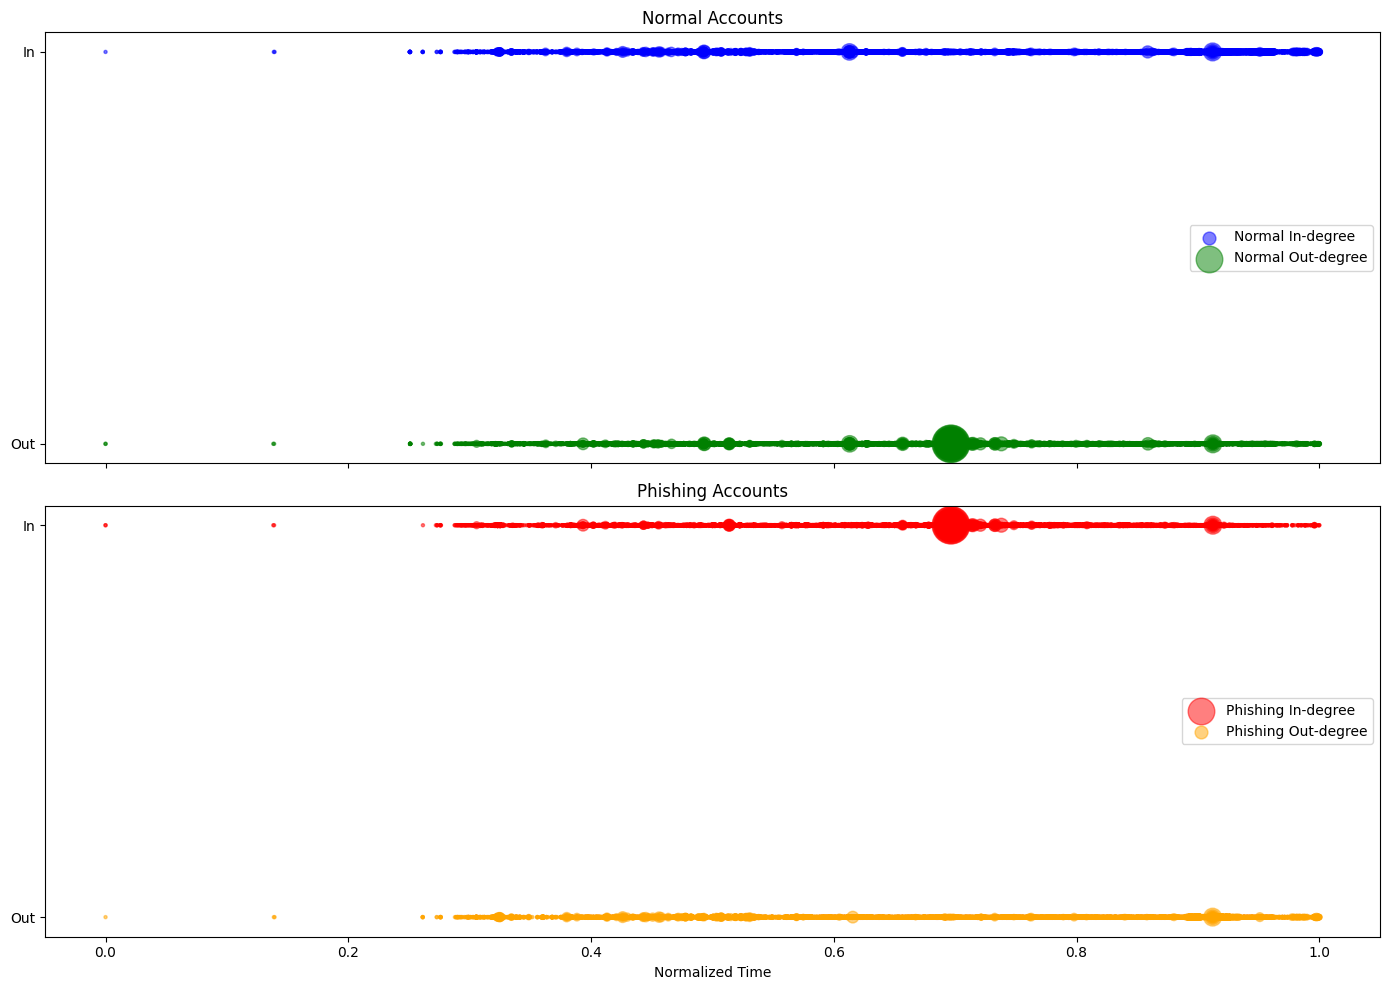

In [39]:
# Normal accounts: In-transactions
normal_in_tx = transaction_data[~transaction_data['To'].isin(phishing_addresses_list)]
normal_in_tx['NormalizedTime'] = (normal_in_tx['TimeStamp'] - normal_in_tx['TimeStamp'].min()) / (normal_in_tx['TimeStamp'].max() - normal_in_tx['TimeStamp'].min())

# Normal accounts: Out-transactions
normal_out_tx = transaction_data[~transaction_data['From'].isin(phishing_addresses_list)]
normal_out_tx['NormalizedTime'] = (normal_out_tx['TimeStamp'] - normal_out_tx['TimeStamp'].min()) / (normal_out_tx['TimeStamp'].max() - normal_out_tx['TimeStamp'].min())

# Phishing accounts: In-transactions
phishing_in_tx = transaction_data[transaction_data['To'].isin(phishing_addresses_list)]
phishing_in_tx['NormalizedTime'] = (phishing_in_tx['TimeStamp'] - phishing_in_tx['TimeStamp'].min()) / (phishing_in_tx['TimeStamp'].max() - phishing_in_tx['TimeStamp'].min())

# Phishing accounts: Out-transactions
phishing_out_tx = transaction_data[transaction_data['From'].isin(phishing_addresses_list)]
phishing_out_tx['NormalizedTime'] = (phishing_out_tx['TimeStamp'] - phishing_out_tx['TimeStamp'].min()) / (phishing_out_tx['TimeStamp'].max() - phishing_out_tx['TimeStamp'].min())

# Group transactions by NormalizedTime and sum the Value for bubble sizes
normal_in_bubble_data = normal_in_tx.groupby('NormalizedTime')['weight'].agg(['sum', 'count']).reset_index()
normal_out_bubble_data = normal_out_tx.groupby('NormalizedTime')['weight'].agg(['sum', 'count']).reset_index()
phishing_in_bubble_data = phishing_in_tx.groupby('NormalizedTime')['weight'].agg(['sum', 'count']).reset_index()
phishing_out_bubble_data = phishing_out_tx.groupby('NormalizedTime')['weight'].agg(['sum', 'count']).reset_index()

# Plot the bubble charts
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Normal accounts
ax[0].scatter(normal_in_bubble_data['NormalizedTime'], np.ones_like(normal_in_bubble_data['NormalizedTime']),
              s=normal_in_bubble_data['count']*5, alpha=0.5, c='blue', label='Normal In-degree')
ax[0].scatter(normal_out_bubble_data['NormalizedTime'], np.zeros_like(normal_out_bubble_data['NormalizedTime']),
              s=normal_out_bubble_data['count']*5, alpha=0.5, c='green', label='Normal Out-degree')
ax[0].set_title('Normal Accounts')
ax[0].set_yticks([0, 1], ['Out', 'In'])

# Phishing accounts
ax[1].scatter(phishing_in_bubble_data['NormalizedTime'], np.ones_like(phishing_in_bubble_data['NormalizedTime']),
              s=phishing_in_bubble_data['count']*5, alpha=0.5, c='red', label='Phishing In-degree')
ax[1].scatter(phishing_out_bubble_data['NormalizedTime'], np.zeros_like(phishing_out_bubble_data['NormalizedTime']),
              s=phishing_out_bubble_data['count']*5, alpha=0.5, c='orange', label='Phishing Out-degree')
ax[1].set_title('Phishing Accounts')
ax[1].set_xlabel('Normalized Time')
ax[1].set_yticks([0, 1], ['Out', 'In'])

# Adding legends
ax[0].legend()
ax[1].legend()

# Display the plot
plt.tight_layout()
plt.show()

## Node2Vec Embeddings

In [14]:
# # Ensure all edge weights are positive and finite
for u, v, data in G.edges(data=True):
    if np.isinf(data['weight']) or np.isnan(data['weight']):
        data['weight'] = 1.0  # Replace non-finite weight with a default positive value

# # Normalize weights to prevent overflow in computations
max_weight = max([data['weight'] for _, _, data in G.edges(data=True)])
for u, v, data in G.edges(data=True):
    data['weight'] /= max_weight

# # check if any node has no outgoing edges or problematic weights sum
for node in G.nodes():
    total_outgoing_weight = sum(d['weight'] for _, _, d in G.out_edges(node, data=True))
    if not np.isfinite(total_outgoing_weight) or total_outgoing_weight == 0:
        for _, neighbor, data in G.out_edges(node, data=True):
            data['weight'] = 1.0 / G.out_degree(node)

In [ ]:
if any(np.isinf(data['weight']) or np.isnan(data['weight']) for _, _, data in G.edges(data=True)):
    print("There are still non-finite weights in the graph.")
if any(data['weight'] <= 0 for _, _, data in G.edges(data=True)):
    print("There are non-positive weights in the graph.")

There are non-positive weights in the graph.


In [15]:
# # Adjusting zero outgoing weights

# # Set a default minimum positive weight
min_positive_weight = 0.1

# # Update all non-positive weights in the graph
for u, v, key, data in G.edges(data=True, keys=True):
    if data['weight'] <= 0:
        G[u][v][key]['weight'] = min_positive_weight

In [ ]:
# # Load the saved Node2Vec model
model = Word2Vec.load("node2vec_model.model")

print("Model loaded successfully!")

# Now you can use the model, for example, to get embeddings:
# To get the embedding for a node, use:
node_id = '0x5c743a35e903f6c584514ec617acee0611cf44f3'  # replace this with your actual node ID
embedding = model.wv[node_id]

print(f"Embedding for node {node_id}: {embedding}")


Model loaded successfully!
Embedding for node 0x5c743a35e903f6c584514ec617acee0611cf44f3: [ 5.2829391e-01  6.3149351e-01  7.0077628e-01 -8.2936049e-01
  2.7299991e-01 -5.7677561e-01 -1.2726106e-01 -7.8026153e-02
  4.0484637e-01 -6.0296196e-01  1.0485927e+00 -7.9226035e-01
  7.5214803e-01 -7.3852855e-01  9.7886026e-01 -8.4171689e-01
 -2.0140636e-01 -8.5168153e-01  4.8188958e-02  3.6016813e-01
  6.4537507e-01 -5.5302286e-01  1.6397637e-01 -5.0146978e-02
 -6.0120535e-01  6.8654436e-01  3.9210418e-01 -1.2328318e+00
  8.6881608e-01  2.6938957e-01  3.6980304e-01  7.9351652e-01
 -9.6098346e-01 -3.1513634e-01 -1.1293728e+00  7.0367873e-01
 -9.6463352e-01  1.1174220e+00  3.3389789e-01  2.2523883e-01
  6.2527454e-01  7.2207320e-01  4.5079330e-01  7.3493755e-01
 -4.6961680e-01  5.6764859e-01  6.4994150e-01 -2.7314672e-01
  4.1449854e-01 -1.4499203e+00  1.4069773e-01 -8.7859595e-01
  4.3134993e-01  1.0463748e+00  5.6686872e-01  8.8021660e-01
  2.0785993e-01 -1.9771694e-01 -8.0518734e-01  3.8380688

In [ ]:
# # Generate Node2Vec model; previously run and model saved

# # Adjust the parameters to reduce computational load
# dimensions = 64
# walk_length = 30
# num_walks = 200

# #  Assuming the graph G is now cleaned and prepared
# node2vec = Node2Vec(G, dimensions=dimensions, walk_length=walk_length, num_walks=num_walks, workers=4)

# #  Fit the model
# model = node2vec.fit(window=10, min_count=1, batch_words=4)

# print("Node2Vec model trained successfully!")

# # Save model
# model.save("node2vec_model.model")
# print("Model saved successfully.")

#WARNING: Takes a lot of time to run


In [ ]:
# Example: Access the embedding for a specific node, if applicable
example_node = '0x5c743a35e903f6c584514ec617acee0611cf44f3'  # Replace with an actual node ID from your graph
if example_node in model.wv:
    print(f"Embedding for node {example_node}: {model.wv[example_node]}")
else:
    print(f"No embedding found for node {example_node}.")

Embedding for node 0x5c743a35e903f6c584514ec617acee0611cf44f3: [ 5.2829391e-01  6.3149351e-01  7.0077628e-01 -8.2936049e-01
  2.7299991e-01 -5.7677561e-01 -1.2726106e-01 -7.8026153e-02
  4.0484637e-01 -6.0296196e-01  1.0485927e+00 -7.9226035e-01
  7.5214803e-01 -7.3852855e-01  9.7886026e-01 -8.4171689e-01
 -2.0140636e-01 -8.5168153e-01  4.8188958e-02  3.6016813e-01
  6.4537507e-01 -5.5302286e-01  1.6397637e-01 -5.0146978e-02
 -6.0120535e-01  6.8654436e-01  3.9210418e-01 -1.2328318e+00
  8.6881608e-01  2.6938957e-01  3.6980304e-01  7.9351652e-01
 -9.6098346e-01 -3.1513634e-01 -1.1293728e+00  7.0367873e-01
 -9.6463352e-01  1.1174220e+00  3.3389789e-01  2.2523883e-01
  6.2527454e-01  7.2207320e-01  4.5079330e-01  7.3493755e-01
 -4.6961680e-01  5.6764859e-01  6.4994150e-01 -2.7314672e-01
  4.1449854e-01 -1.4499203e+00  1.4069773e-01 -8.7859595e-01
  4.3134993e-01  1.0463748e+00  5.6686872e-01  8.8021660e-01
  2.0785993e-01 -1.9771694e-01 -8.0518734e-01  3.8380688e-04
  1.1489556e+00  6.083

## Node2Vec for Node Classification

In [ ]:
# # extract node labels
node_labels = {str(node): G.nodes[node]['fraud'] for node in G.nodes()}

# Extract embeddings for nodes that have labels
embeddings = []
labels = []
for node in G.nodes():
    node_str = str(node)  # Convert node to string to match dictionary keys
    if node_str in model.wv:
        embeddings.append(model.wv[node_str])
        if node_str in node_labels:
            labels.append(node_labels[node_str])
        else:
            print(f"No label found for node {node_str}, skipping...")  # handle missing labels

embeddings = np.array(embeddings)
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)



In [ ]:
# # run node classification experiment for Node2Vec embeddings

node2vec_results_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class'])
node2vec_results_list = []


for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(embeddings, targets, test_size=0.3)
  smote = SMOTE()
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # upsample fraud nodes using smote for class imbalance
  # #Scale features (important for SVM)
  scaler = StandardScaler()
  X_train_resampled = scaler.fit_transform(X_train_resampled)
  X_test = scaler.transform(X_test)
  # # Define classifiers
  classifiers = {
      "Logistic Regression": LogisticRegression(),
      "SVM": SVC(),
      "Random Forest": RandomForestClassifier(n_estimators=100),
      "KNN": KNeighborsClassifier(n_neighbors=3)
  }

  # # Train each classifier and evaluate its performance
  for name, clf in classifiers.items():
      clf.fit(X_train_resampled, y_train_resampled)
      y_pred = clf.predict(X_test)
      print(f"Classification Report for {name}:")
      print(classification_report(y_test, y_pred))
      accuracy = accuracy_score(y_test, y_pred)
      print(f"Accuracy of {name}: {accuracy:.2f}")

      accuracy = accuracy_score(y_test, y_pred)
      precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0,1])

      # # Store results for each class of each classifier
      for cls_index, cls in enumerate([0, 1]):
          node2vec_results_list.append({
              'Classifier': name,
              'Iteration': i,
              'Accuracy': accuracy,
              'Precision': precision[cls_index],
              'Recall': recall[cls_index],
              'F1-Score': f1_score[cls_index],
              'Class': cls
          })

node2vec_results_df = pd.DataFrame(node2vec_results_list)

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      6490
           1       0.10      0.78      0.18       158

    accuracy                           0.83      6648
   macro avg       0.55      0.81      0.54      6648
weighted avg       0.97      0.83      0.89      6648

Accuracy of Logistic Regression: 0.83
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      6490
           1       0.12      0.20      0.15       158

    accuracy                           0.95      6648
   macro avg       0.55      0.58      0.56      6648
weighted avg       0.96      0.95      0.95      6648

Accuracy of SVM: 0.95
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6490
           1       0.22      0.38      0.28       158

   

In [ ]:
# # save results

node2vec_results_df
node2vec_results_df.to_csv('node2vec df.csv')

In [16]:
# # aggregate scores based on desired grouping and metric

def agg_results(df, score, group):
  agg = df.groupby(group).agg(
  Mean_F1=(score, 'mean'),
  SD_F1=(score, 'std')
  ).reset_index()

  return agg

In [ ]:
# # show aggregated results for each classifier by class

node2vec_agg_results = agg_results(node2vec_results_df, 'F1-Score', ['Classifier', 'Class'])
node2vec_agg_results

,Classifier,Class,Mean_F1,SD_F1
0,KNN,0,0.976329,0.001183
1,KNN,1,0.178809,0.025436
2,Logistic Regression,0,0.903845,0.009893
3,Logistic Regression,1,0.191608,0.019050
4,Random Forest,0,0.976777,0.001440
5,Random Forest,1,0.315963,0.031780
6,SVM,0,0.973660,0.001333
7,SVM,1,0.180110,0.023354


In [ ]:
# # show aggregated results for each classifier, classes combined

agg_results(node2vec_results_df, 'F1-Score', ['Classifier'])

,Classifier,Mean_F1,SD_F1
0,KNN,0.577569,0.409494
1,Logistic Regression,0.547726,0.365669
2,Random Forest,0.646370,0.339697
3,SVM,0.576885,0.407401


In [17]:
def plot_results(df, title):
  # # Determine how many unique classifiers and classes there are

  classifiers = df['Classifier'].unique()
  classes = df['Class'].unique()
  num_classes = len(classes)

  # # Generate a base color for each classifier
  base_colors = [plt.cm.tab10(i) for i in range(len(classifiers))]

  # # Prepare a dictionary to hold colors for each classifier and its classes
  color_dict = {}
  for i, classifier in enumerate(classifiers):
      classifier_colors = [base_colors[i] for _ in range(num_classes)]  # Same color, different alphas
      # # Adjust alpha to create different shades
      for j in range(num_classes):
          classifier_colors[j] = classifier_colors[j][:3] + (0.5 + j * 0.5 / num_classes,)  # Increasing alpha
      color_dict[classifier] = classifier_colors

  plt.figure(figsize=(12, 8))

  # # Width of a bar
  width = 0.35

  # # Create bars for each classifier and class
  positions = []
  labels = []
  for i, (index, row) in enumerate(df.iterrows()):
      # # Calculate position for each bar
      pos = i * width
      positions.append(pos)
      labels.append(f'{row["Classifier"]} - Real' if i % num_classes == 0 else f'{row["Classifier"]} - Scam')

      # # Select the color
      classifier_index = np.where(classifiers == row['Classifier'])[0][0]
      class_index = int(row['Class']) - min(classes)  # Assuming classes are 0-indexed or similar
      bar_color = color_dict[row['Classifier']][class_index]

      # # Plotting the bar at the calculated position with error bar
      plt.bar(pos, row['Mean_F1'], width, yerr=row['SD_F1'], color=bar_color, capsize=5, label=f'{row["Classifier"]} - Real' if i % num_classes == 0 else f'{row["Classifier"]} - Scam')

  plt.xticks(positions, labels, rotation=90)
  plt.ylabel('Average F1-Score')
  plt.xlabel('Classifier and Class')
  plt.title(title)

  handles, labels = plt.gca().get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  plt.legend(by_label.values(), by_label.keys(), title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')

  plt.tight_layout()
  plt.show()

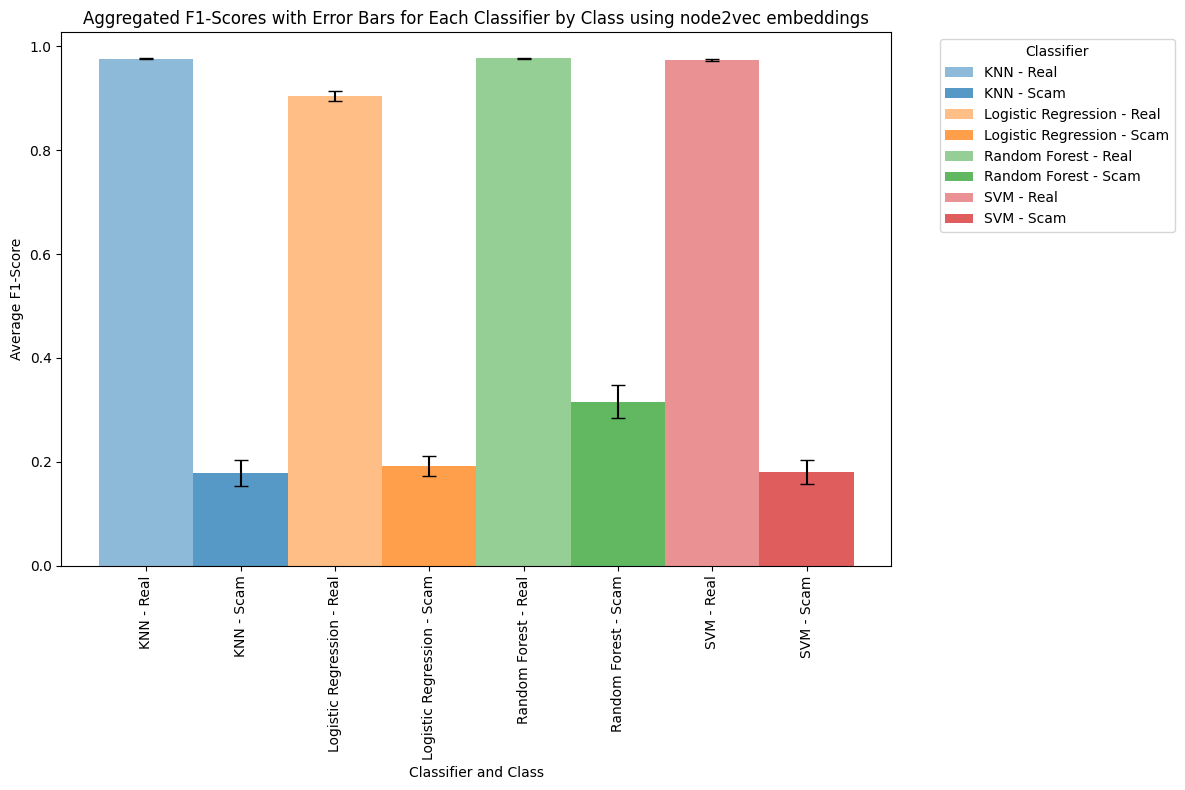

In [ ]:
plot_results(node2vec_agg_results, 'Aggregated F1-Scores with Error Bars for Each Classifier by Class using node2vec embeddings')

## GraphSAGE Embeddings

In [ ]:
# # create GraphSAGE embeddings

node_features = np.array([[G.degree(node, weight='weight')] for node in G.nodes()])
labels = np.array([G.nodes[node]['fraud'] for node in G.nodes()])
scaler = StandardScaler()
node_features = scaler.fit_transform(node_features)
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)
node_id_to_index = {node: idx for idx, node in enumerate(G.nodes())}
edges = [(node_id_to_index[u], node_id_to_index[v]) for u, v in G.edges()]
edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

# Define GraphSAGE model for embeddings
class GraphSAGEEmbedding(torch.nn.Module):
    def __init__(self):
        super(GraphSAGEEmbedding, self).__init__()
        self.conv1 = SAGEConv(1, 128)
        self.conv2 = SAGEConv(128, 256)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return x

sage_model_embedding = GraphSAGEEmbedding()

## GraphSAGE for Node Classification

In [ ]:
class GraphSAGEClassifier(torch.nn.Module):
    def __init__(self):
        super(GraphSAGEClassifier, self).__init__()
        self.sage = GraphSAGEEmbedding()
        self.classifier = torch.nn.Linear(256, 2)

    def forward(self, x, edge_index):
        x = self.sage(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.classifier(x)
        return x

In [ ]:
# # training and evaluation process for GraphSAGE

def train_and_evaluate_sage(model, data):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    train_idx, test_idx = train_test_split(range(len(data.y)), test_size=0.3)
    train_mask = torch.zeros(len(data.y), dtype=torch.bool).scatter_(0, torch.tensor(train_idx), True)
    test_mask = torch.zeros(len(data.y), dtype=torch.bool).scatter_(0, torch.tensor(test_idx), True)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                logits = model(data.x, data.edge_index)
                test_loss = criterion(logits[test_mask], data.y[test_mask])
                preds = logits[test_mask].argmax(dim=1)
                correct = preds.eq(data.y[test_mask]).sum().item()
                acc = correct / test_mask.sum().item()
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Accuracy: {acc:.4f}')

    # # Final evaluation for detailed classification report
    model.eval()
    with torch.no_grad():
        final_logits = model(data.x, data.edge_index)
        final_preds = final_logits[test_mask].argmax(dim=1)
        print("\nFinal Classification Report:")
        print(classification_report(data.y[test_mask].numpy(), final_preds.numpy(), target_names=['Non-Phishing', 'Phishing']))

        precision, recall, f1_score, support = precision_recall_fscore_support(data.y[test_mask].numpy(), final_preds.numpy(), average=None, labels=[0,1])
        accuracy = accuracy_score(data.y[test_mask].numpy(), final_preds.numpy())

    # # Store results for each class
    results = []
    for classifier_index, classifier in enumerate([0, 1]):
        results.append({
            'Classifier': 'GraphSAGE',
            'Iteration': i,
            'Accuracy': accuracy,
            'Precision': precision[classifier_index],
            'Recall': recall[classifier_index],
            'F1-Score': f1_score[classifier_index],
            'Class': classifier
          })
    return results

In [ ]:
# # Run experiments to evaluate GraphSAGE and save results

graphsage_results_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class'])
graphsage_results_list = []

for i in range(10):
  sage_classifier = GraphSAGEClassifier()
  graphsage_results_list = graphsage_results_list + train_and_evaluate_sage(sage_classifier, data)

graphsage_results_df = pd.DataFrame(graphsage_results_list)
display(graphsage_results_df)
graphsage_results_df.to_csv('graphsage df.csv')


Epoch 0, Loss: 0.7111, Test Loss: 0.2217, Accuracy: 0.9771
Epoch 10, Loss: 0.0782, Test Loss: 0.0724, Accuracy: 0.9777
Epoch 20, Loss: 0.0727, Test Loss: 0.0671, Accuracy: 0.9777
Epoch 30, Loss: 0.0611, Test Loss: 0.0600, Accuracy: 0.9779
Epoch 40, Loss: 0.0570, Test Loss: 0.0562, Accuracy: 0.9786
Epoch 50, Loss: 0.0547, Test Loss: 0.0551, Accuracy: 0.9789
Epoch 60, Loss: 0.0531, Test Loss: 0.0530, Accuracy: 0.9795
Epoch 70, Loss: 0.0514, Test Loss: 0.0517, Accuracy: 0.9795
Epoch 80, Loss: 0.0497, Test Loss: 0.0502, Accuracy: 0.9796
Epoch 90, Loss: 0.0477, Test Loss: 0.0487, Accuracy: 0.9796

Final Classification Report:
              precision    recall  f1-score   support

Non-Phishing       0.98      1.00      0.99     11372
    Phishing       0.66      0.23      0.34       266

    accuracy                           0.98     11638
   macro avg       0.82      0.61      0.66     11638
weighted avg       0.97      0.98      0.97     11638

Epoch 0, Loss: 0.6092, Test Loss: 0.1847, Ac

,Classifier,Iteration,Accuracy,Precision,Recall,F1-Score,Class
0,GraphSAGE,0,0.979636,0.982160,0.997274,0.989659,0
1,GraphSAGE,0,0.979636,0.659341,0.225564,0.336134,1
2,GraphSAGE,1,0.980409,0.982452,0.997805,0.990069,0
3,GraphSAGE,1,0.980409,0.642857,0.181452,0.283019,1
4,GraphSAGE,2,0.980495,0.982430,0.997890,0.990100,0
5,GraphSAGE,2,0.980495,0.714286,0.228137,0.345821,1
6,GraphSAGE,3,0.980925,0.982186,0.998593,0.990322,0
7,GraphSAGE,3,0.980925,0.783784,0.219697,0.343195,1
8,GraphSAGE,4,0.979378,0.981075,0.998154,0.989541,0
9,GraphSAGE,4,0.979378,0.681818,0.170455,0.272727,1


In [ ]:
# # show aggregated results for each classifier by class

graphsage_agg_results = agg_results(graphsage_results_df, 'F1-Score', ['Class', 'Classifier'])
graphsage_agg_results

,Class,Classifier,Mean_F1,SD_F1
0,0,GraphSAGE,0.989965,0.000738
1,1,GraphSAGE,0.312956,0.032779


In [ ]:
# # show aggregated results for each classifier, combined classes

agg_results(graphsage_results_df, 'F1-Score', ['Classifier'])

,Classifier,Mean_F1,SD_F1
0,GraphSAGE,0.651461,0.34803


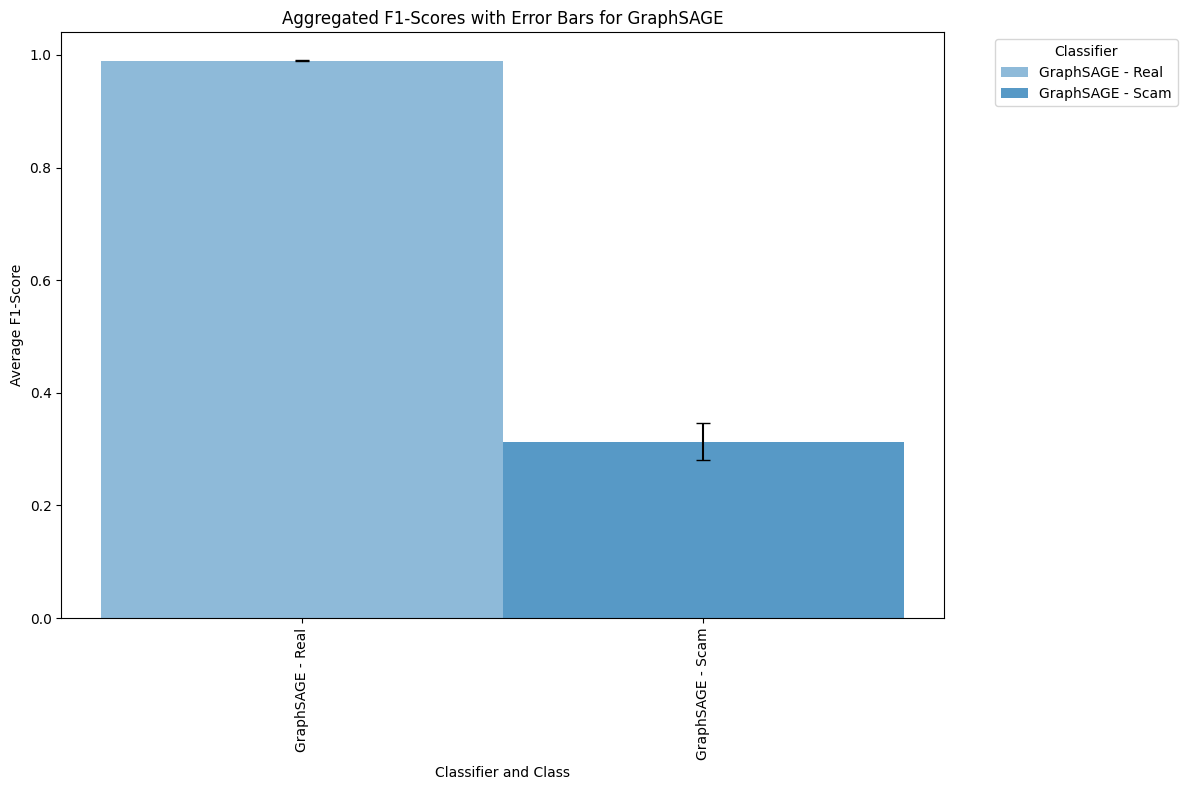

In [ ]:
plot_results(graphsage_agg_results, 'Aggregated F1-Scores with Error Bars for GraphSAGE')

## GCN Embeddings

In [ ]:
class GCNEmbedding(torch.nn.Module):
    def __init__(self):
        super(GCNEmbedding, self).__init__()
        self.conv1 = GCNConv(1, 128)
        self.conv2 = GCNConv(128, 256)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        return x

gcn_model_embedding = GCNEmbedding()

In [ ]:
class GCNClassifier(torch.nn.Module):
    def __init__(self):
        super(GCNClassifier, self).__init__()
        self.gcn = GCNEmbedding()
        self.classifier = torch.nn.Linear(256, 2)

    def forward(self, x, edge_index):
        x = self.gcn(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.classifier(x)
        return x

In [ ]:
# # train and evaluate gcn model

def train_and_evaluate_gcn(model, data):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    train_idx, test_idx = train_test_split(range(len(data.y)), test_size=0.3)
    train_mask = torch.zeros(len(data.y), dtype=torch.bool).scatter_(0, torch.tensor(train_idx), True)
    test_mask = torch.zeros(len(data.y), dtype=torch.bool).scatter_(0, torch.tensor(test_idx), True)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                logits = model(data.x, data.edge_index)
                test_loss = criterion(logits[test_mask], data.y[test_mask])
                preds = logits[test_mask].argmax(dim=1)
                correct = preds.eq(data.y[test_mask]).sum().item()
                acc = correct / test_mask.sum().item()
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}, Accuracy: {acc:.4f}')

    # # Final evaluation for detailed classification report
    model.eval()
    with torch.no_grad():
        final_logits = model(data.x, data.edge_index)
        final_preds = final_logits[test_mask].argmax(dim=1)
        print("\nFinal Classification Report:")
        print(classification_report(data.y[test_mask].numpy(), final_preds.numpy(), target_names=['Non-Phishing', 'Phishing']))
        precision, recall, f1_score, support = precision_recall_fscore_support(data.y[test_mask].numpy(), final_preds.numpy(), average=None, labels=[0,1])
        accuracy = accuracy_score(data.y[test_mask].numpy(), final_preds.numpy())


    results = []
    for classifier_index, classifier in enumerate([0, 1]):
        results.append({
            'Classifier': 'GCN',
            'Iteration': i,
            'Accuracy': accuracy,
            'Precision': precision[classifier_index],
            'Recall': recall[classifier_index],
            'F1-Score': f1_score[classifier_index],
            'Class': classifier
          })
    return results

gcn_results_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class'])
gcn_results_list = []

for i in range(10):
  gcn_classifier = GCNClassifier()
  gcn_results_list = gcn_results_list + train_and_evaluate_gcn(gcn_classifier, data)

gcn_results_df = pd.DataFrame(gcn_results_list)

Epoch 0, Loss: 0.7303, Test Loss: 0.6470, Accuracy: 0.9781
Epoch 10, Loss: 0.2392, Test Loss: 0.2290, Accuracy: 0.9781
Epoch 20, Loss: 0.1153, Test Loss: 0.1045, Accuracy: 0.9781
Epoch 30, Loss: 0.0566, Test Loss: 0.0530, Accuracy: 0.9874
Epoch 40, Loss: 0.0426, Test Loss: 0.0401, Accuracy: 0.9836
Epoch 50, Loss: 0.0350, Test Loss: 0.0316, Accuracy: 0.9839
Epoch 60, Loss: 0.0334, Test Loss: 0.0295, Accuracy: 0.9881
Epoch 70, Loss: 0.0319, Test Loss: 0.0295, Accuracy: 0.9869
Epoch 80, Loss: 0.0308, Test Loss: 0.0277, Accuracy: 0.9880
Epoch 90, Loss: 0.0299, Test Loss: 0.0269, Accuracy: 0.9888

Final Classification Report:
              precision    recall  f1-score   support

Non-Phishing       1.00      0.99      0.99     11383
    Phishing       0.73      0.84      0.78       255

    accuracy                           0.99     11638
   macro avg       0.86      0.92      0.89     11638
weighted avg       0.99      0.99      0.99     11638

Epoch 0, Loss: 0.6923, Test Loss: 0.6475, Ac

In [ ]:
# # save results

gcn_results_df
gcn_results_df.to_csv('gcn df.csv')

In [ ]:
# # show aggregated results for each classifier by class

gcn_agg_results = agg_results(gcn_results_df, 'F1-Score', ['Class', 'Classifier'])
gcn_agg_results

,Class,Classifier,Mean_F1,SD_F1
0,0,GCN,0.993945,0.000597
1,1,GCN,0.749082,0.039305


In [ ]:
# # show aggregated results for each classifier, classes combined

agg_results(gcn_results_df, 'F1-Score', ['Classifier'])

,Classifier,Mean_F1,SD_F1
0,GCN,0.871513,0.128493


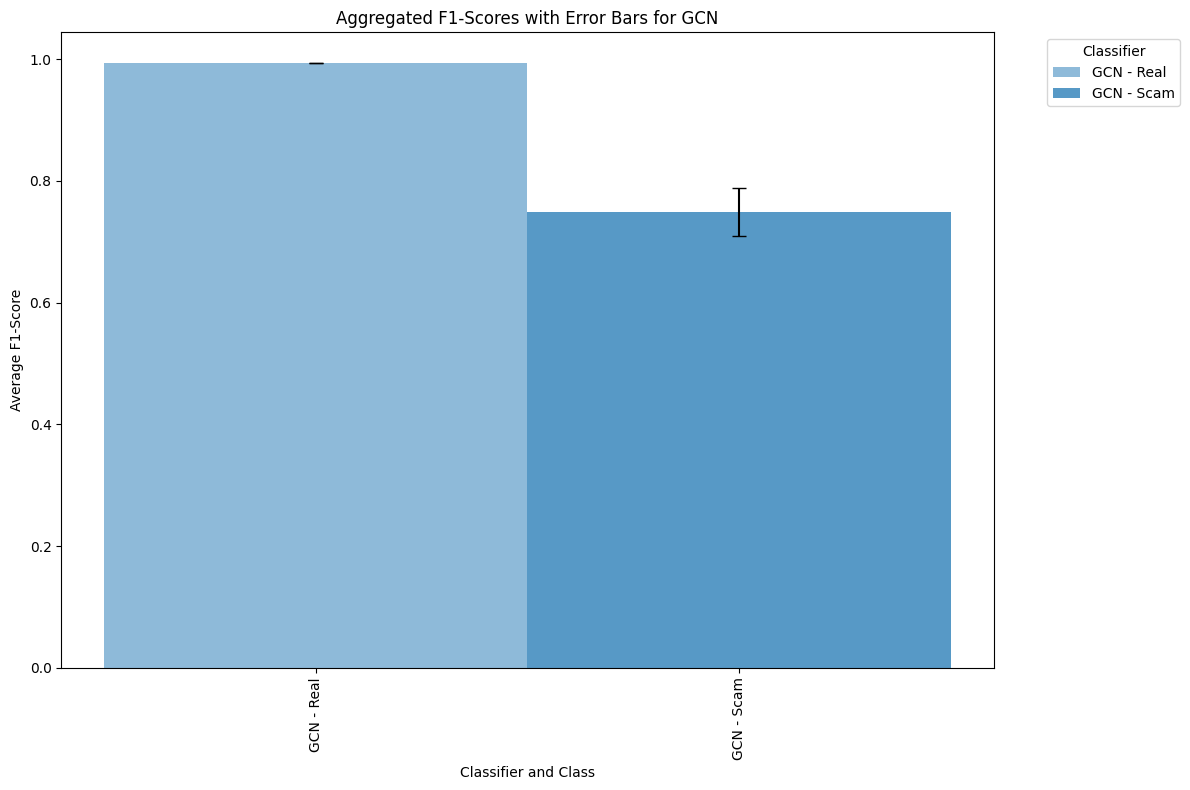

In [ ]:
plot_results(gcn_agg_results, 'Aggregated F1-Scores with Error Bars for GCN')

## Graph2Vec Embeddings

In [ ]:
node_mapping = {node: i for i, node in enumerate(G.nodes())}

# # Relabel nodes
G_relabelled = nx.relabel_nodes(G, node_mapping)

# # Initialize the Graph2Vec model
model = Graph2Vec(dimensions=64, workers=4)

# # Fit the model on the relabelled graph
model.fit([G_relabelled])  # Note that fit expects a list of graphs

# # Get the embedding
embedding = model.get_embedding()
print("Graph2Vec embedding for the graph:", embedding)


Graph2Vec embedding for the graph: [[ 0.9650469   1.1312338   0.96436554 -0.9258276  -1.0250143  -0.54697424
  -0.51731837  0.55619484 -0.80506784 -1.0214016  -0.5585006   1.1730928
  -0.5627927   0.18112697  1.062244    0.5233834  -0.11737522  1.12723
  -0.7184812   0.6677877   0.4871826  -0.42513216 -0.11273163 -1.0638903
   0.0063684  -0.32061952  1.1975422  -0.5702037  -0.8163353   0.1356944
  -0.94453704 -0.96240854 -0.7920898  -0.7365842  -0.52534175 -0.23723565
  -0.29999548  0.69675934  0.82567024 -0.5479249  -0.7663938   0.09426182
  -0.54478693  0.0031214   0.86705226  0.46930847 -0.65370715 -0.15500994
   0.02210375 -0.976524    1.1915063   1.0046912  -0.00360345  0.70679754
   0.54446983  1.0464143   0.44104648 -1.1212807  -0.29619655  0.43345967
  -0.06920147  0.59224576  0.42599282  0.53467077]]


In [ ]:
# # run experiments for GCN model

# # Get the embedding
graph_embedding = model.get_embedding()

# # Generate dummy node features based on node degree
node_features = np.array([np.append(G.degree(node, weight='weight'), graph_embedding) for node in G.nodes()])

# # each node in G has a 'fraud' attribute as label
labels = np.array([G.nodes[node]['fraud'] for node in G.nodes()])

graph2vec_results_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class'])
graph2vec_results_list = []


for i in range(10):
  # # Split the dataset into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(node_features, labels, test_size=0.3)
  smote = SMOTE()
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # upsample fraud nodes
  # # Scale features (important for SVM)
  scaler = StandardScaler()
  X_train_resampled = scaler.fit_transform(X_train_resampled)
  X_test = scaler.transform(X_test)
  # # Classifier initialization
  classifiers = {
      "Logistic Regression": LogisticRegression(),
      "Random Forest": RandomForestClassifier(n_estimators=100),
      "Support Vector Machine": SVC(),
      "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3)
  }

  # # Train classifiers and evaluate
  for name, clf in classifiers.items():
      clf.fit(X_train_resampled, y_train_resampled)
      y_pred = clf.predict(X_test)
      print(f"{name} Classification Report:")
      print(classification_report(y_test, y_pred))
      print(f"{name} Accuracy:", accuracy_score(y_test, y_pred))

      accuracy = accuracy_score(y_test, y_pred)
      precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0,1])

      # # Store results for each class
      for cls_index, cls in enumerate([0, 1]):
          graph2vec_results_list.append({
              'Classifier': name,
              'Iteration': i,
              'Accuracy': accuracy,
              'Precision': precision[cls_index],
              'Recall': recall[cls_index],
              'F1-Score': f1_score[cls_index],
              'Class': cls
          })
graph2vec_results_df = pd.DataFrame(graph2vec_results_list)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.88      0.93     11399
        True       0.05      0.28      0.08       239

    accuracy                           0.87     11638
   macro avg       0.52      0.58      0.51     11638
weighted avg       0.96      0.87      0.91     11638

Logistic Regression Accuracy: 0.869135590307613
Random Forest Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.95      0.97     11399
        True       0.23      0.69      0.34       239

    accuracy                           0.95     11638
   macro avg       0.61      0.82      0.66     11638
weighted avg       0.98      0.95      0.96     11638

Random Forest Accuracy: 0.9455232857879361
Support Vector Machine Classification Report:
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     11399
        True       0

In [ ]:
# # save results

graph2vec_results_df
graph2vec_results_df.to_csv('graph2vec df.csv')

In [ ]:
# # show aggregated results for each classifier by class

graph2vec_agg_results = agg_results(graph2vec_results_df, 'F1-Score', ['Classifier', 'Class'])
graph2vec_agg_results

,Classifier,Class,Mean_F1,SD_F1
0,K-Nearest Neighbors,0,0.957375,0.001840
1,K-Nearest Neighbors,1,0.303205,0.021933
2,Logistic Regression,0,0.928314,0.001916
3,Logistic Regression,1,0.084069,0.009883
4,Random Forest,0,0.975737,0.003785
5,Random Forest,1,0.372267,0.031400
6,Support Vector Machine,0,0.986790,0.000586
7,Support Vector Machine,1,0.255360,0.021115


In [ ]:
# # show aggregated results for each classifier, classes combined

agg_results(graph2vec_results_df, 'F1-Score', ['Classifier'])

,Classifier,Mean_F1,SD_F1
0,K-Nearest Neighbors,0.630290,0.335923
1,Logistic Regression,0.506192,0.433144
2,Random Forest,0.674002,0.310338
3,Support Vector Machine,0.621075,0.375497


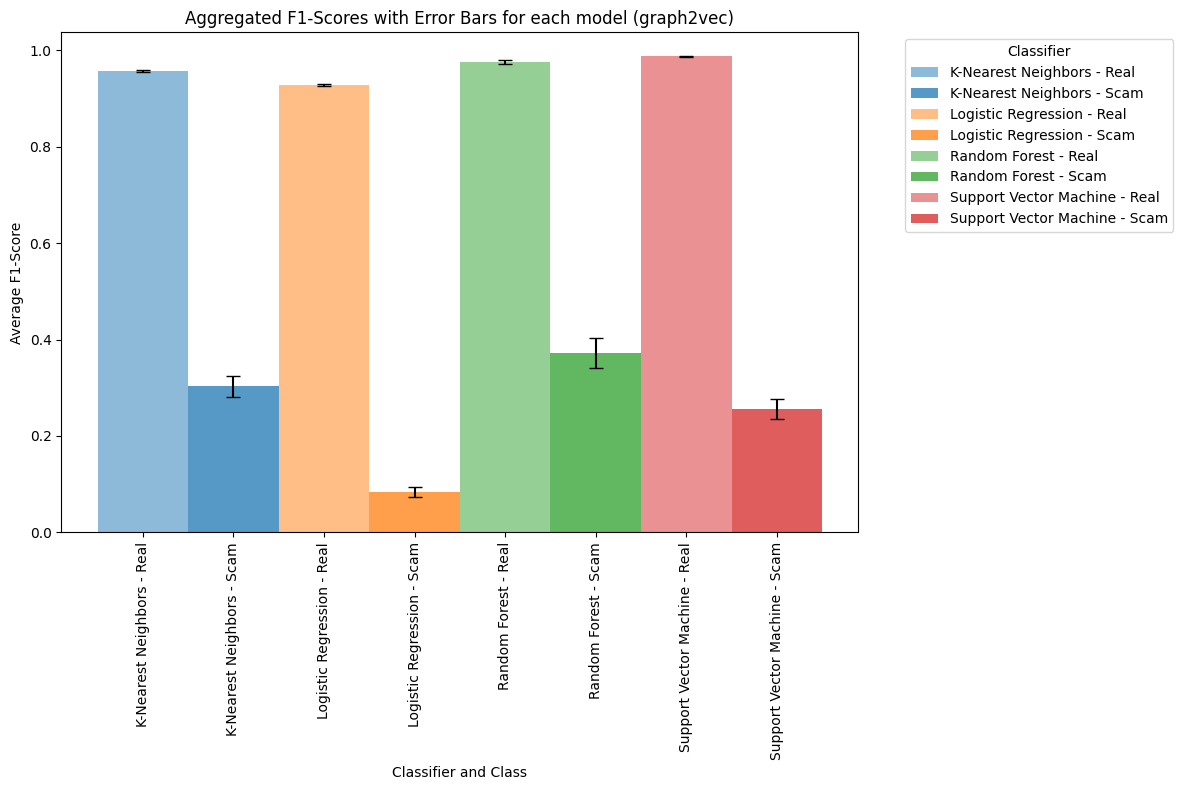

In [ ]:
plot_results(graph2vec_agg_results, 'Aggregated F1-Scores with Error Bars for each model (graph2vec)')

## Egoggraphs graph2vec

In [122]:
# Simplify multidigraph to digraph
G_di = nx.DiGraph()

# Iterate over edges in the MultiDiGraph and sum them up
for u, v in G.edges():
    if G_di.has_edge(u, v):
        # If the edge already exists, increment the weight
        G_di[u][v]['weight'] += 1
    else:
        # Otherwise, create the edge with weight 1
        G_di.add_edge(u, v, weight=1, timestamp=row['TimeStamp'])
for node in G_di.nodes():
    G_di.nodes[node]['fraud'] = node in phishing_addresses_list

In [55]:
# Calculate appropriate alpha for katz_centrality convergence
A = nx.adjacency_matrix(G_di, weight='weight').astype(float)  # Convert A to float
try:
    largest_eigenvalue = np.abs(eigs(A, k=1, which='LM', return_eigenvectors=False)[0])
    alpha = 1 / largest_eigenvalue * 0.9  # Using 90% of the reciprocal value as a safety margin
    print(f"Calculated alpha: {alpha}")
except Exception as e:
    print(f"Failed to compute the largest eigenvalue: {e}")

Calculated alpha: 0.0037825001813016667


In [ ]:
# # WARNING: takes a long time
# katz = nx.katz_centrality(G_di, max_iter=50000, alpha=alpha, weight = 'weight')
# sorted_katz = sorted(katz.items(), key=lambda x: x[1], reverse=True)

In [ ]:
# # save ordered katz nodes

# # Open a file and use pickle.dump to serialize the list
# with open('sorted_centrality.pkl', 'wb') as f:
#     pickle.dump(sorted_katz, f)


In [18]:
# # Load pickle file containing sorted nodes by katz centrality
with open('sorted_centrality.pkl', 'rb') as f: sorted_katz = pickle.load(f)

In [19]:
def create_egographs(addresses, k):
  egographs = {}
  for address in addresses:
      # Make sure the node is in the graph
      if address in G:
          # This will give you the subgraph up to k hops away from the phishing address
          k_hop_ego = nx.ego_graph(G, address, radius=k)
          egographs[address] = G.subgraph(k_hop_ego).copy()
  return egographs

In [20]:
# # Generate desired k-egographs
k = 2

focal_addresses = [node for node in G.nodes()]
full_phishing_subgraphs = create_egographs(focal_addresses, k)
full_phishing_subgraphs_copy = copy.deepcopy(full_phishing_subgraphs) # might run out of ram during embedding process; ; used for gcn egographs

katz_non_phishing = [n[0] for n in sorted_katz if n[0] not in phishing_addresses_list]
katz_non_phishing_addresses = katz_non_phishing[:890]
katz_focal_addresses = phishing_addresses_list + katz_non_phishing_addresses
katz_phishing_subgraphs = create_egographs(katz_focal_addresses, k)
katz_phishing_subgraphs_copy = copy.deepcopy(katz_phishing_subgraphs) # might run out of ram during embedding process; used for gcn egographs

In [21]:
# Assuming phishing_subgraphs is your dictionary of ego-graphs keyed by phishing addresses

def calculate_transaction_weights(ego_graph, center_node, attr_name):
    weights = {node: 0 for node in ego_graph.nodes()}
    for u, v, data in ego_graph.edges(data=True):
        if u != center_node and attr_name in data:
            weights[u] += data[attr_name]
        if v != center_node and attr_name in data:
            weights[v] += data[attr_name]
    return weights

def amount_based_relabel(ego_graph, center_node):
    wa = calculate_transaction_weights(ego_graph, center_node, 'Value')
    da_c = np.mean(list(wa.values()))
    ya = {node: 1 if wa[node] >= da_c else 0 for node in ego_graph.nodes()}
    return ya

def number_based_relabel(ego_graph, center_node):
    wn = {node: ego_graph.degree(node) for node in ego_graph.nodes()}
    dn_c = np.mean(list(wn.values()))
    yn = {node: 1 if wn[node] >= dn_c else 0 for node in ego_graph.nodes()}
    return yn

def direction_based_relabel(ego_graph, center_node):
    # Initialize the weights
    wd_in = {node: 0 for node in ego_graph.nodes()}
    wd_out = {node: 0 for node in ego_graph.nodes()}

    # Calculate the in-degree and out-degree for each node based on transaction directions
    for node in ego_graph.nodes():
        wd_in[node] = ego_graph.in_degree(node, weight='Value')  # Sum of incoming transaction values
        wd_out[node] = ego_graph.out_degree(node, weight='Value')  # Sum of outgoing transaction values

    # Assign a direction-based label based on the comparison of wd_in and wd_out
    yd = {node: (0 if wd_in[node] == wd_out[node] else (1 if wd_in[node] > wd_out[node] else -1))
          for node in ego_graph.nodes()}

    return yd

# Function to relabel the nodes of a graph to use integer labels starting from 0
def relabel_graph_nodes(graph):
    mapping = {node: i for i, node in enumerate(graph.nodes())}
    return nx.relabel_nodes(graph, mapping)

# Function to combine the relabels into a single composite label
def combine_labels(amount_label, number_label, direction_label):
    # Mapping the combination of labels to a unique number
    label_mapping = {
        (0, 0, -1): 1, (0, 0, 0): 2, (0, 0, 1): 3,
        (0, 1, -1): 4, (0, 1, 0): 5, (0, 1, 1): 6,
        (1, 0, -1): 7, (1, 0, 0): 8, (1, 0, 1): 9,
        (1, 1, -1): 10, (1, 1, 0): 11, (1, 1, 1): 12,
    }
    return label_mapping[(amount_label, number_label, direction_label)]

In [22]:
def apply_relabel(subgraphs):
  for address, subgraph in subgraphs.items():
    amount_labels = amount_based_relabel(subgraph, address)
    number_labels = number_based_relabel(subgraph, address)
    direction_labels = direction_based_relabel(subgraph, address)

    # Annotate nodes with their new labels
    for node in subgraph.nodes():
        subgraph.nodes[node]['amount_label'] = amount_labels[node]
        subgraph.nodes[node]['number_label'] = number_labels[node]
        subgraph.nodes[node]['direction_label'] = direction_labels[node]


In [23]:
def apply_combined_labels(subgraphs):
  for address, subgraph in subgraphs.items():
    for node in subgraph.nodes():
        amount_label = subgraph.nodes[node]['amount_label']
        number_label = subgraph.nodes[node]['number_label']
        direction_label = subgraph.nodes[node]['direction_label']

        # Combine the labels into a single composite label
        composite_label = combine_labels(amount_label, number_label, direction_label)

        # Assign the composite label to the node
        subgraph.nodes[node]['composite_label'] = composite_label


In [24]:
def graph_embeds(subgraphs):
  # # Relabel nodes in each subgraph and store in a new list
  relabelled_graphs = [relabel_graph_nodes(subgraph) for address, subgraph in subgraphs.items()]

  # Initialize the Graph2Vec model with desired parameters
  graph2vec_model = Graph2Vec(wl_iterations=2, dimensions=64, workers=4)

  # Fit the model to your list of properly indexed graphs
  graph2vec_model.fit(relabelled_graphs)

  # Get the embeddings for each graph
  graph_embeddings = graph2vec_model.get_embedding()

  return graph_embeddings

In [25]:
full_g_embeddings = graph_embeds(full_phishing_subgraphs)

In [26]:
katz_g_embeddings = graph_embeds(katz_phishing_subgraphs)

In [27]:
# Assuming you have a list of labels corresponding to your subgraphs
# Each label should be 1 if the subgraph corresponds to a phishing address, and 0 otherwise
full_g_labels = [1 if address in phishing_addresses_list else 0 for address, subgraph in full_phishing_subgraphs.items()]

# Combine embeddings and labels into a dataset
full_dataset = list(zip(full_g_embeddings, full_g_labels))

In [28]:
# Each label should be 1 if the subgraph corresponds to a phishing address, and 0 otherwise
katz_labels = [1 if address in phishing_addresses_list else 0 for address, subgraph in katz_phishing_subgraphs.items()]

# Combine embeddings and labels into a dataset
katz_dataset = list(zip(katz_g_embeddings, katz_labels))

In [29]:
X, y = zip(*full_dataset) # Unzip the dataset into features and labels
katz_X, katz_y = zip(*katz_dataset) # Unzip the dataset into features and labels


In [30]:
def run_model(name, classifier, X_train, X_test, y_train, y_test, ego):
  results = []
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  print(f"Classification Report for {name}:")
  print(classification_report(y_test, y_pred))
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy of {name}: {accuracy:.2f}")

  precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0,1])

# Store results for each class
  for classifier_index, classifier in enumerate([0, 1]):
      results.append({
          'Classifier': name,
          'Iteration': i,
          'Accuracy': accuracy,
          'Precision': precision[classifier_index],
          'Recall': recall[classifier_index],
          'F1-Score': f1_score[classifier_index],
          'Class': classifier,
          'Egograph type': ego
      })
  return results

In [31]:
results_full_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class', 'Egograph type'])
results_full_up_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class', 'Egograph type'])
results_katz_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class', 'Egograph type'])

results_full_no_upsampling = []
results_full_upsampling = []
results_katz = []

for i in range(10):
  # Split the dataset into training and testing sets

  # # For full graph, no upscaling
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
  full_scaler = StandardScaler()
  X_train_scaled = full_scaler.fit_transform(X_train)
  X_test_scaled = full_scaler.transform(X_test)

  # # For full graph, upscaling
  smote = SMOTE()
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
  upsampled_scaler = StandardScaler()
  X_train_scaled = upsampled_scaler.fit_transform(X_train_resampled)
  X_test_scaled = upsampled_scaler.transform(X_test)

  # For katz_centrality
  katz_X_train, katz_X_test, katz_y_train, katz_y_test = train_test_split(katz_X, katz_y, test_size=0.3)
  katz_scaler = StandardScaler()
  katz_X_train = katz_scaler.fit_transform(katz_X_train)
  katz_X_test = katz_scaler.transform(katz_X_test)

  # Define classifiers
  classifiers = {
      "Logistic Regression": LogisticRegression(),
      "SVM": SVC(),
      "Random Forest": RandomForestClassifier(n_estimators=100),
      "KNN": KNeighborsClassifier(n_neighbors=3)
  }

  # Train each classifier and evaluate its performance
  for name, clf in classifiers.items():
    results_full_no_upsampling = results_full_no_upsampling + run_model(name, clf, X_train, X_test, y_train, y_test, 'full_no_upsampling')
    results_full_upsampling = results_full_upsampling + run_model(name, clf, X_train_resampled, X_test, y_train_resampled, y_test, 'full_upsampling')
    results_katz = results_katz + run_model(name, clf, katz_X_train, katz_X_test, katz_y_train, katz_y_test, 'katz')

results_full_df = pd.DataFrame(results_full_no_upsampling)
results_full_up_df = pd.DataFrame(results_full_upsampling)
results_katz_df = pd.DataFrame(results_katz)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11399
           1       0.80      0.08      0.15       239

    accuracy                           0.98     11638
   macro avg       0.89      0.54      0.57     11638
weighted avg       0.98      0.98      0.97     11638

Accuracy of Logistic Regression: 0.98


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     11399
           1       0.05      0.79      0.10       239

    accuracy                           0.71     11638
   macro avg       0.52      0.75      0.46     11638
weighted avg       0.97      0.71      0.81     11638

Accuracy of Logistic Regression: 0.71
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.57      0.65      0.61       249
           1       0.65      0.56      0.60       285

    accuracy                           0.60       534
   macro avg       0.61      0.61      0.60       534
weighted avg       0.61      0.60      0.60       534

Accuracy of Logistic Regression: 0.60
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11399
           1       0.77      0.10   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     11371
           1       0.06      0.76      0.11       267

    accuracy                           0.71     11638
   macro avg       0.52      0.73      0.47     11638
weighted avg       0.97      0.71      0.81     11638

Accuracy of Logistic Regression: 0.71
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.57      0.64      0.60       258
           1       0.62      0.56      0.59       276

    accuracy                           0.60       534
   macro avg       0.60      0.60      0.60       534
weighted avg       0.60      0.60      0.60       534

Accuracy of Logistic Regression: 0.60
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11371
           1       0.76      0.11   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     11363
           1       0.06      0.75      0.11       275

    accuracy                           0.71     11638
   macro avg       0.53      0.73      0.47     11638
weighted avg       0.97      0.71      0.81     11638

Accuracy of Logistic Regression: 0.71
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       275
           1       0.58      0.54      0.56       259

    accuracy                           0.59       534
   macro avg       0.59      0.59      0.59       534
weighted avg       0.59      0.59      0.59       534

Accuracy of Logistic Regression: 0.59
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11363
           1       0.74      0.07   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     11374
           1       0.06      0.79      0.11       264

    accuracy                           0.70     11638
   macro avg       0.53      0.75      0.47     11638
weighted avg       0.97      0.70      0.81     11638

Accuracy of Logistic Regression: 0.70
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.65      0.62       266
           1       0.62      0.56      0.59       268

    accuracy                           0.61       534
   macro avg       0.61      0.61      0.61       534
weighted avg       0.61      0.61      0.61       534

Accuracy of Logistic Regression: 0.61
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11374
           1       0.63      0.10   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     11366
           1       0.06      0.78      0.11       272

    accuracy                           0.71     11638
   macro avg       0.53      0.74      0.47     11638
weighted avg       0.97      0.71      0.81     11638

Accuracy of Logistic Regression: 0.71
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       263
           1       0.61      0.56      0.59       271

    accuracy                           0.60       534
   macro avg       0.60      0.60      0.60       534
weighted avg       0.60      0.60      0.60       534

Accuracy of Logistic Regression: 0.60
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11366
           1       0.81      0.10   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     11368
           1       0.06      0.84      0.12       270

    accuracy                           0.70     11638
   macro avg       0.53      0.77      0.47     11638
weighted avg       0.97      0.70      0.80     11638

Accuracy of Logistic Regression: 0.70
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       275
           1       0.62      0.61      0.61       259

    accuracy                           0.63       534
   macro avg       0.63      0.63      0.63       534
weighted avg       0.63      0.63      0.63       534

Accuracy of Logistic Regression: 0.63
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11368
           1       0.74      0.11   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     11373
           1       0.06      0.78      0.11       265

    accuracy                           0.71     11638
   macro avg       0.53      0.74      0.47     11638
weighted avg       0.97      0.71      0.81     11638

Accuracy of Logistic Regression: 0.71
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       251
           1       0.66      0.55      0.60       283

    accuracy                           0.61       534
   macro avg       0.61      0.61      0.61       534
weighted avg       0.62      0.61      0.61       534

Accuracy of Logistic Regression: 0.61
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11373
           1       0.71      0.10   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     11372
           1       0.06      0.76      0.10       266

    accuracy                           0.70     11638
   macro avg       0.52      0.73      0.46     11638
weighted avg       0.97      0.70      0.81     11638

Accuracy of Logistic Regression: 0.70
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.58      0.67      0.62       260
           1       0.64      0.54      0.58       274

    accuracy                           0.60       534
   macro avg       0.61      0.61      0.60       534
weighted avg       0.61      0.60      0.60       534

Accuracy of Logistic Regression: 0.60
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11372
           1       0.72      0.09   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82     11400
           1       0.05      0.82      0.10       238

    accuracy                           0.71     11638
   macro avg       0.52      0.76      0.46     11638
weighted avg       0.98      0.71      0.81     11638

Accuracy of Logistic Regression: 0.71
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       264
           1       0.60      0.54      0.57       270

    accuracy                           0.58       534
   macro avg       0.59      0.58      0.58       534
weighted avg       0.59      0.58      0.58       534

Accuracy of Logistic Regression: 0.58
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11400
           1       0.79      0.11   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     11357
           1       0.06      0.80      0.12       281

    accuracy                           0.71     11638
   macro avg       0.53      0.75      0.47     11638
weighted avg       0.97      0.71      0.81     11638

Accuracy of Logistic Regression: 0.71
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       276
           1       0.63      0.63      0.63       258

    accuracy                           0.64       534
   macro avg       0.64      0.64      0.64       534
weighted avg       0.64      0.64      0.64       534

Accuracy of Logistic Regression: 0.64
Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11357
           1       0.88      0.10   

In [32]:
ego_g2v_results_df = pd.concat([results_full_df, results_full_up_df, results_katz_df], ignore_index=True)
display(ego_g2v_results_df )
ego_g2v_results_df .to_csv('egograph g2v df.csv')

,Classifier,Iteration,Accuracy,Precision,Recall,F1-Score,Class,Egograph type
0,Logistic Regression,0,0.980753,0.981142,0.999561,0.990266,0,full_no_upsampling
1,Logistic Regression,0,0.980753,0.800000,0.083682,0.151515,1,full_no_upsampling
2,SVM,0,0.980839,0.981392,0.999386,0.990307,0,full_no_upsampling
3,SVM,0,0.980839,0.766667,0.096234,0.171004,1,full_no_upsampling
4,Random Forest,0,0.981268,0.982564,0.998596,0.990515,0,full_no_upsampling
...,...,...,...,...,...,...,...,...
235,SVM,9,0.764045,0.789474,0.697674,0.740741,1,katz
236,Random Forest,9,0.764045,0.784091,0.750000,0.766667,0,katz
237,Random Forest,9,0.764045,0.744444,0.779070,0.761364,1,katz
238,KNN,9,0.741573,0.773810,0.706522,0.738636,0,katz


In [33]:
def label_bar(cls, scam, graph_type):
  classifier = cls
  fraud = scam
  graph = graph_type
  if fraud ==0:
    return f'{classifier} {graph_type} - Real'
  else:
    return f'{classifier} {graph_type} - Scam'


In [34]:
def plot_agg(agg_df, title):
    classifiers = agg_df['Classifier'].unique()
    classes = agg_df['Class'].unique()
    graph_types = agg_df['Egograph type'].unique()

    # Generate a base color for each classifier
    base_colors = [plt.cm.tab10(i) for i in range(len(classifiers))]

    # Prepare a dictionary to hold colors for each classifier and its classes
    color_dict = {}
    label_dict = {}  # Dictionary to hold the labels for legend handling
    for i, classifier in enumerate(classifiers):
        color_dict[classifier] = {}
        for j, cls in enumerate(classes):
            color_dict[classifier][cls] = {}
            base_color = base_colors[i][:3]  # Get RGB components, ignore the default alpha
            for k, graph_type in enumerate(graph_types):
                # Modify alpha to create different shades for each graph type
                alpha = 0.5 + k * 0.5 / len(graph_types)
                color_dict[classifier][cls][graph_type] = (*base_color, alpha)  # Creating a new RGBA tuple
                label = f"{classifier} - {cls} - {graph_type}"
                color_dict[classifier][cls][graph_type] = (*base_color, alpha)
                label_dict[label] = (*base_color, alpha)

    plt.figure(figsize=(14, 8))
    width = 0.25  # Width of the bars

    for i, row in agg_df.iterrows():
        classifier = row['Classifier']
        cls = row['Class']
        graph_type = row['Egograph type']
        color = color_dict[classifier][cls][graph_type]
        label = f"{classifier} - {cls} - {graph_type}"

        # Calculate position for each bar
        pos = i * width
        # Plotting the bar at the calculated position with error bar
        plt.bar(pos, row['Mean_F1'], width, yerr=row['SD_F1'], color=color, capsize=5, label=label)

    # Customize axes
    positions = np.arange(len(agg_df)) * width
    plt.xticks(positions, [f"{row['Classifier']} - {row['Class']} - {row['Egograph type']}" for _, row in agg_df.iterrows()], rotation=90)
    plt.ylabel('Average F1-Score')
    plt.xlabel('Classifier and Class')
    plt.title(title)
    plt.ylim(0.0, 1.0)

    # Handling legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Classifier - Class - Graph Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

In [35]:
# # show aggregated results for each classifier by class and egograph type

agg_ego_g2v =  agg_results(ego_g2v_results_df, 'F1-Score', ['Classifier', 'Class', 'Egograph type'])
agg_ego_g2v

,Classifier,Class,Egograph type,Mean_F1,SD_F1
0,KNN,0,full_no_upsampling,0.989029,0.000542
1,KNN,0,full_upsampling,0.915871,0.002739
2,KNN,0,katz,0.719100,0.015269
3,KNN,1,full_no_upsampling,0.381825,0.024662
4,KNN,1,full_upsampling,0.173918,0.009793
5,KNN,1,katz,0.729832,0.014858
6,Logistic Regression,0,full_no_upsampling,0.988967,0.000683
7,Logistic Regression,0,full_upsampling,0.824854,0.003142
8,Logistic Regression,0,katz,0.619774,0.018002
9,Logistic Regression,1,full_no_upsampling,0.122948,0.021385


In [36]:
# # show aggregated results for each classifier and egograph type, combined classes

agg_results(ego_g2v_results_df, 'F1-Score', ['Classifier', 'Egograph type'])

,Classifier,Egograph type,Mean_F1,SD_F1
0,KNN,full_no_upsampling,0.685427,0.311951
1,KNN,full_upsampling,0.544895,0.380678
2,KNN,katz,0.724466,0.015663
3,Logistic Regression,full_no_upsampling,0.555958,0.444502
4,Logistic Regression,full_upsampling,0.466636,0.367552
5,Logistic Regression,katz,0.606182,0.023313
6,Random Forest,full_no_upsampling,0.609960,0.389830
7,Random Forest,full_upsampling,0.699937,0.295170
8,Random Forest,katz,0.758289,0.010117
9,SVM,full_no_upsampling,0.581835,0.418260


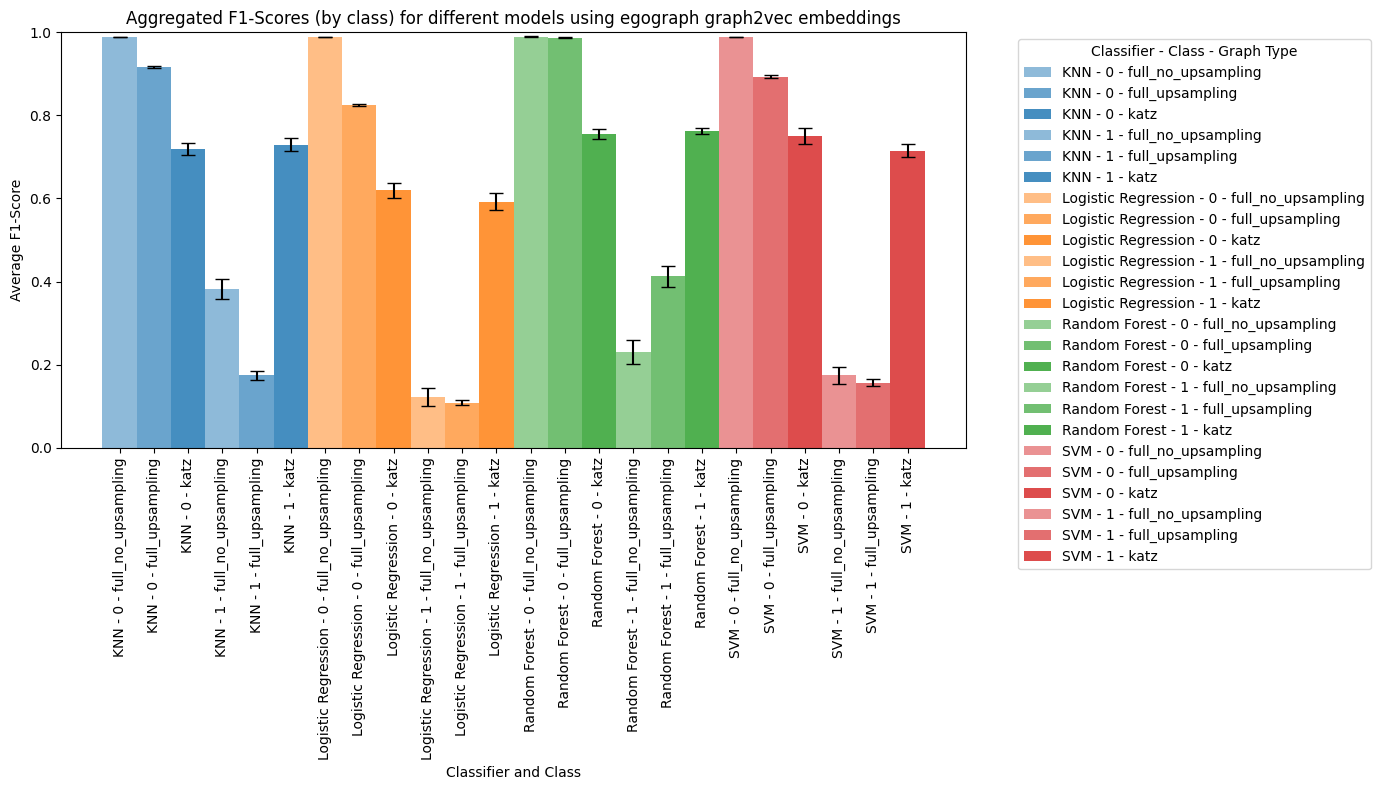

In [37]:
plot_agg(agg_ego_g2v, 'Aggregated F1-Scores (by class) for different models using egograph graph2vec embeddings')

## Egographs GNN

In [19]:
def augment_features(ego_graph, target_node):
    # Calculate the augmented features for nodes in the ego-graph
    for node in ego_graph.nodes():
        # Initialize features with structural features
        features = np.zeros(6)  # Placeholder for 6 features

        # Structural features: in-degree and out-degree
        features[0] = ego_graph.in_degree(node, weight='weight')
        features[1] = ego_graph.out_degree(node, weight='weight')

        # Transaction features: Collecting transaction values for in and out transactions
        transactions_in = [data['weight'] for u, v, data in ego_graph.in_edges(node, data=True)]
        transactions_out = [data['weight'] for u, v, data in ego_graph.out_edges(node, data=True)]

        features[2] = max(transactions_in) if transactions_in else 0  # Max transaction amount in (AF_TO)
        features[3] = max(transactions_out) if transactions_out else 0  # Max transaction amount out (AF_TI)

        # Interaction intensity features
        features[4] = sum(np.abs(transactions_in)) / features[0] if features[0] > 0 else 0  # Interaction intensity in (RT_in)
        features[5] = sum(np.abs(transactions_out)) / features[1] if features[1] > 0 else 0  # Interaction intensity out (RT_out)


        # Gather timestamps from all outgoing edges of this node
        timestamps = [data['TimeStamp'] for _, _, data in ego_graph.edges(node, data=True)]


        # Update the node's features in the ego_graph
        ego_graph.nodes[node]['features'] = features.tolist()

    return ego_graph

In [20]:
# Assuming subgraphs is a dictionary where the key is the address of the central node
# and the value is the corresponding ego-graph (subgraph).
for address, ego_graph in full_phishing_subgraphs_copy.items():
    full_phishing_subgraphs_copy[address] = augment_features(ego_graph, address)

for address, ego_graph in katz_phishing_subgraphs_copy.items():
    katz_phishing_subgraphs_copy[address] = augment_features(ego_graph, address)


In [21]:
def convert_to_pyg(subgraphs, phishing_addresses_list):

  # Assuming `phishing_addresses_list` is your list of phishing addresses
  pyg_graphs = []  # This will store the PyTorch Geometric Data objects.
  labs = []

  for address, ego_graph in subgraphs.items():

      # Get the features and label for each node in the ego_graph
      node_features = []
      node_labels = []
      nodes = []

      if address in phishing_addresses_list:
        labs.append(1)
      else:
        labs.append(0)


      for node in ego_graph.nodes(data=True):

        node_features.append(node[1]['features'])  # Assuming 'features' is where you store them

        node_labels.append(1 if node[0] in phishing_addresses_list else 0)
      # Convert to PyTorch tensors
      node_features_tensor = torch.tensor(node_features, dtype=torch.float)
      node_labels_tensor = torch.tensor(node_labels, dtype=torch.long)
      # node_labels_tensor = torch.tensor(labs, dtype=torch.long)

      # Create a mapping from node identifiers to consecutive integers
      node_mapping = {node: i for i, node in enumerate(ego_graph.nodes())}

      # # Create integer pairs for the edges using the mapping
      edge_list = [(node_mapping[edge[0]], node_mapping[edge[1]]) for edge in ego_graph.edges]
      # # Convert the edge list to a tensor
      edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()


      # # Create a PyTorch Geometric Data object
      data = Data(x=node_features_tensor, edge_index=edge_index, y=node_labels_tensor)

      # # Add to your list of graph Data objects
      pyg_graphs.append(data)


  return pyg_graphs, labs

In [22]:
full_pyg, full_labs = convert_to_pyg(full_phishing_subgraphs_copy, phishing_addresses_list)
katz_pyg, katz_labs = convert_to_pyg(katz_phishing_subgraphs_copy, phishing_addresses_list)

In [23]:
def label_pyg(pyg_graphs, labs):
  graphs_class_0 = []
  graphs_class_1 =  []

  for i in range(len(pyg_graphs)):
    if labs[i]==1:
      graphs_class_1.append(pyg_graphs[i])
    else:
      graphs_class_0.append(pyg_graphs[i])
  return graphs_class_0, graphs_class_1

In [24]:
full_pyg0, full_pyg1 = label_pyg(full_pyg, full_labs)
katz_pyg0, katz_pyg1 = label_pyg(katz_pyg, katz_labs)


In [25]:
# Define the GCN model class
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [26]:
def evaluate_with_metrics(loader, device, model_gcn, name, ego):
    model_gcn.eval()
    all_preds = []
    all_labels = []
    results = []

    with torch.no_grad():  # No need to track gradients for evaluation
        for data in loader:
            data = data.to(device)
            out = model_gcn(data.x, data.edge_index)
            preds = out.argmax(dim=1)  # Get the predicted class
            all_preds.append(preds[data.test_mask].cpu())  # Store predictions
            all_labels.append(data.y[data.test_mask].cpu())  # Store true labels

    # Concatenate the results from each batch
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    accuracy = accuracy_score(all_labels, all_preds)  # Overall accuracy
    report = classification_report(all_labels, all_preds)
    confusion_m = confusion_matrix(all_labels, all_preds)
    print(report)
    precision, recall, f1_score, support = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=[0,1])

  # Store results for each class
    for classifier_index, classifier in enumerate([0, 1]):
        results.append({
            'Classifier': name,
            'Iteration': i,
            'Accuracy': accuracy,
            'Precision': precision[classifier_index],
            'Recall': recall[classifier_index],
            'F1-Score': f1_score[classifier_index],
            'Class': classifier,
            'Egograph type': ego
        })


    return results

In [27]:
def run_pyg_model(graphs_class_0, graphs_class_1, name, ego):
  results_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class', 'Egograph type'])

  # Split the data into training and testing sets
  train_graphs_0, test_graphs_0 = train_test_split(graphs_class_0, test_size=0.2)
  train_graphs_1, test_graphs_1 = train_test_split(graphs_class_1, test_size=0.2)

  # Right after splitting, set masks:
  for graph_list in [train_graphs_0, train_graphs_1, test_graphs_0, test_graphs_1]:
      for graph in graph_list:
          num_nodes = graph.num_nodes
          train_mask = torch.zeros(num_nodes, dtype=torch.bool)
          test_mask = torch.zeros(num_nodes, dtype=torch.bool)
          train_mask[:num_nodes//2] = True
          test_mask[num_nodes//2:] = True
          graph.train_mask = train_mask
          graph.test_mask = test_mask

  train_graphs = train_graphs_0 + train_graphs_1
  test_graphs = test_graphs_0 + test_graphs_1


  # Define the batch size
  batch_size = 32

  # Create PyTorch Geometric DataLoaders for training and testing sets
  train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

    # Define the device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Instantiate the GCN model
  model_gcn = GCN(in_channels=6, hidden_channels=16, out_channels=2).to(device)

  # Define the optimizer and criterion
  optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.01)
  criterion = torch.nn.CrossEntropyLoss()

  # Define the training loop
  model_gcn.train()

  for epoch in range(20):
    total_loss = 0
    for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      out = model_gcn(data.x, data.edge_index)  # Pass node features and edge index to the model
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Use train_mask for computing loss
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    print(total_loss)
    print(f'Epoch {epoch}, Loss: {total_loss / len(train_loader)}')
  results_list = evaluate_with_metrics(test_loader, device, model_gcn, name, ego)
  # print(accuracy, precision, recall, f1, report, confusion)

  results_df = pd.DataFrame(results_list)
  return results_df


In [28]:
ego_gcn_results_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class', 'Egograph type'])
for i in range(10):
  ego_gcn_results_df = pd.concat([run_pyg_model(katz_pyg0, katz_pyg1, 'ego_gcn', 'katz'), ego_gcn_results_df])
  ego_gcn_results_df = pd.concat([run_pyg_model(full_pyg0, full_pyg1, 'ego_gcn', 'full'), ego_gcn_results_df])


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


32.37045341730118
Epoch 0, Loss: 0.7193434092733595
23.97381693124771
Epoch 1, Loss: 0.5327514873610603
23.304000973701477
Epoch 2, Loss: 0.5178666883044772
22.176153510808945
Epoch 3, Loss: 0.4928034113513099
22.13241684436798
Epoch 4, Loss: 0.49183148543039956
21.68664202094078
Epoch 5, Loss: 0.4819253782431285
21.30058278143406
Epoch 6, Loss: 0.47334628403186796
21.28941483795643
Epoch 7, Loss: 0.47309810751014286
24.440515398979187
Epoch 8, Loss: 0.5431225644217597
20.784370094537735
Epoch 9, Loss: 0.46187489098972745
21.25849550962448
Epoch 10, Loss: 0.4724110113249885
20.45453467965126
Epoch 11, Loss: 0.4545452151033613
20.75986447930336
Epoch 12, Loss: 0.4613303217622969
20.382246106863022
Epoch 13, Loss: 0.45293880237473383
20.311986535787582
Epoch 14, Loss: 0.4513774785730574
20.36592061817646
Epoch 15, Loss: 0.45257601373725465
20.294688671827316
Epoch 16, Loss: 0.4509930815961626
20.448311284184456
Epoch 17, Loss: 0.4544069174263212
19.953307688236237
Epoch 18, Loss: 0.44340

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


134.12866150215268
Epoch 0, Loss: 0.13827697062077596
107.98525178804994
Epoch 1, Loss: 0.11132500184335045
107.67743759974837
Epoch 2, Loss: 0.11100766762860657
101.46000023558736
Epoch 3, Loss: 0.10459793838720347
101.94013191759586
Epoch 4, Loss: 0.10509291950267614
102.14969233050942
Epoch 5, Loss: 0.10530896116547363
101.8232151735574
Epoch 6, Loss: 0.1049723867768633
102.801335176453
Epoch 7, Loss: 0.10598075791386907
99.78089400194585
Epoch 8, Loss: 0.10286690103293387
104.64251768402755
Epoch 9, Loss: 0.10787888421033769
100.2560951448977
Epoch 10, Loss: 0.10335679911845123
98.62868532910943
Epoch 11, Loss: 0.101679057040319
97.19868741929531
Epoch 12, Loss: 0.1002048323910261
96.21463570930064
Epoch 13, Loss: 0.09919034609206251
99.06950282491744
Epoch 14, Loss: 0.10213350806692519
93.87507529743016
Epoch 15, Loss: 0.09677842814168057
97.84831931255758
Epoch 16, Loss: 0.1008745559923274
96.05917867459357
Epoch 17, Loss: 0.09903008110782842
97.39063952676952
Epoch 18, Loss: 0.1

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


34.27933609485626
Epoch 0, Loss: 0.7617630243301392
24.91251701116562
Epoch 1, Loss: 0.5536114891370137
24.197433650493622
Epoch 2, Loss: 0.5377207477887471
21.20903342962265
Epoch 3, Loss: 0.47131185399161446
22.173326790332794
Epoch 4, Loss: 0.4927405953407288
23.333439633250237
Epoch 5, Loss: 0.5185208807388941
21.040978953242302
Epoch 6, Loss: 0.46757731007205117
21.330359116196632
Epoch 7, Loss: 0.47400798035992514
20.115046814084053
Epoch 8, Loss: 0.44700104031297894
20.23122376203537
Epoch 9, Loss: 0.44958275026745265
20.100323423743248
Epoch 10, Loss: 0.4466738538609611
19.426442824304104
Epoch 11, Loss: 0.4316987294289801
20.62285478413105
Epoch 12, Loss: 0.45828566186957886
19.637951403856277
Epoch 13, Loss: 0.43639892008569503
19.427672117948532
Epoch 14, Loss: 0.4317260470655229
19.796488046646118
Epoch 15, Loss: 0.43992195659213595
20.036528825759888
Epoch 16, Loss: 0.4452561961279975
20.43451927602291
Epoch 17, Loss: 0.4541004283560647
19.107292026281357
Epoch 18, Loss: 0

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


139.24809924513102
Epoch 0, Loss: 0.14355474148982578
110.77122537605464
Epoch 1, Loss: 0.11419713956294293
104.26839913241565
Epoch 2, Loss: 0.1074931949818718
99.08660620637238
Epoch 3, Loss: 0.10215114041894059
99.50583872944117
Epoch 4, Loss: 0.1025833388963311
100.6719733569771
Epoch 5, Loss: 0.10378553954327537
96.34833694435656
Epoch 6, Loss: 0.09932818241686243
95.75988827645779
Epoch 7, Loss: 0.09872153430562658
98.61371395550668
Epoch 8, Loss: 0.10166362263454297
97.66254878044128
Epoch 9, Loss: 0.10068303997983638
97.58698722533882
Epoch 10, Loss: 0.10060514146942146
96.29989717714489
Epoch 11, Loss: 0.0992782445125205
93.83733914513141
Epoch 12, Loss: 0.09673952489188806
96.0962209161371
Epoch 13, Loss: 0.09906826898570835
95.80046326853335
Epoch 14, Loss: 0.09876336419436428
93.81494471244514
Epoch 15, Loss: 0.09671643784788159
98.60235941410065
Epoch 16, Loss: 0.10165191692175324
92.76331446319818
Epoch 17, Loss: 0.0956322829517507
95.22790412604809
Epoch 18, Loss: 0.0981

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


33.73407855629921
Epoch 0, Loss: 0.7496461901399825
22.72037860751152
Epoch 1, Loss: 0.5048973023891449
21.096547320485115
Epoch 2, Loss: 0.468812162677447
21.664686262607574
Epoch 3, Loss: 0.48143747250239055
20.449191942811012
Epoch 4, Loss: 0.4544264876180225
20.015261188149452
Epoch 5, Loss: 0.44478358195887674
18.90269972383976
Epoch 6, Loss: 0.4200599938631058
21.22612801194191
Epoch 7, Loss: 0.4716917335987091
20.06415966153145
Epoch 8, Loss: 0.4458702147006989
20.4496109187603
Epoch 9, Loss: 0.45443579819467333
18.91596168279648
Epoch 10, Loss: 0.420354704062144
20.054147139191628
Epoch 11, Loss: 0.4456477142042584
18.841430753469467
Epoch 12, Loss: 0.41869846118821036
20.01314413547516
Epoch 13, Loss: 0.44473653634389243
19.394147038459778
Epoch 14, Loss: 0.4309810452991062
18.558853521943092
Epoch 15, Loss: 0.41241896715429094
17.712084278464317
Epoch 16, Loss: 0.3936018728547626
18.28592759370804
Epoch 17, Loss: 0.4063539465268453
18.154878228902817
Epoch 18, Loss: 0.4034417

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


144.03712906315923
Epoch 0, Loss: 0.14849188563212293
107.69210503064096
Epoch 1, Loss: 0.11102278869138243
96.24865404702723
Epoch 2, Loss: 0.09922541654332705
95.29550302773714
Epoch 3, Loss: 0.09824278662653313
93.75524935126305
Epoch 4, Loss: 0.09665489623841551
94.02440047636628
Epoch 5, Loss: 0.09693237162511988
94.38086138200015
Epoch 6, Loss: 0.09729985709484551
93.19066670536995
Epoch 7, Loss: 0.09607285227357727
92.14000342786312
Epoch 8, Loss: 0.09498969425552899
90.8695955388248
Epoch 9, Loss: 0.0936799954008503
90.70160580798984
Epoch 10, Loss: 0.09350681011132973
91.11484476365149
Epoch 11, Loss: 0.09393282965324896
93.66806750558317
Epoch 12, Loss: 0.09656501804699295
91.92827508226037
Epoch 13, Loss: 0.0947714176105777
90.84181915968657
Epoch 14, Loss: 0.09365135995843976
91.68611795827746
Epoch 15, Loss: 0.09452177109100769
90.86138094216585
Epoch 16, Loss: 0.09367152674450088
91.27450129948556
Epoch 17, Loss: 0.09409742402008821
92.72073138691485
Epoch 18, Loss: 0.095

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


36.130527049303055
Epoch 0, Loss: 0.8029006010956234
25.19448782503605
Epoch 1, Loss: 0.5598775072230233
21.738015204668045
Epoch 2, Loss: 0.4830670045481788
19.640798822045326
Epoch 3, Loss: 0.43646219604545167
19.05485051870346
Epoch 4, Loss: 0.42344112263785466
18.410838782787323
Epoch 5, Loss: 0.4091297507286072
18.272535249590874
Epoch 6, Loss: 0.4060563388797972
18.8788490742445
Epoch 7, Loss: 0.4195299794276555
17.677856907248497
Epoch 8, Loss: 0.39284126460552216
17.628859892487526
Epoch 9, Loss: 0.39175244205527837
17.976493656635284
Epoch 10, Loss: 0.3994776368141174
16.810806944966316
Epoch 11, Loss: 0.37357348766591814
17.916549131274223
Epoch 12, Loss: 0.3981455362505383
17.676375836133957
Epoch 13, Loss: 0.3928083519140879
17.48772280663252
Epoch 14, Loss: 0.38861606236961155
17.725976675748825
Epoch 15, Loss: 0.3939105927944183
17.73624277114868
Epoch 16, Loss: 0.3941387282477485
17.443702518939972
Epoch 17, Loss: 0.3876378337542216
16.805493742227554
Epoch 18, Loss: 0.3

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


136.30259633623064
Epoch 0, Loss: 0.14051814055281509
110.82393872924149
Epoch 1, Loss: 0.11425148322602216
101.64622969925404
Epoch 2, Loss: 0.10478992752500416
100.76321198418736
Epoch 3, Loss: 0.10387959998369832
99.22502428852022
Epoch 4, Loss: 0.10229383947270125
98.83442104049027
Epoch 5, Loss: 0.10189115571184564
98.85619642212987
Epoch 6, Loss: 0.10191360455889677
97.87395526468754
Epoch 7, Loss: 0.10090098480895622
96.85155779123306
Epoch 8, Loss: 0.09984696679508563
100.62548211216927
Epoch 9, Loss: 0.10373761042491676
95.43520958721638
Epoch 10, Loss: 0.09838681400743957
96.89622231386602
Epoch 11, Loss: 0.09989301269470724
99.73974472098053
Epoch 12, Loss: 0.10282447909379436
95.5277967453003
Epoch 13, Loss: 0.09848226468587659
96.61296389810741
Epoch 14, Loss: 0.09960099370938909
97.8450719807297
Epoch 15, Loss: 0.1008712082275564
97.99976838193834
Epoch 16, Loss: 0.10103068905354468
94.91585749667138
Epoch 17, Loss: 0.09785139948110451
96.28806164488196
Epoch 18, Loss: 0.

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


34.12882775068283
Epoch 0, Loss: 0.7584183944596185
22.571188271045685
Epoch 1, Loss: 0.501581961578793
22.185726523399353
Epoch 2, Loss: 0.4930161449644301
21.60512651503086
Epoch 3, Loss: 0.48011392255624136
21.702201455831528
Epoch 4, Loss: 0.4822711434629228
20.349705800414085
Epoch 5, Loss: 0.45221568445364635
20.362157344818115
Epoch 6, Loss: 0.45249238544040254
20.2640670388937
Epoch 7, Loss: 0.4503126008643044
19.082089319825172
Epoch 8, Loss: 0.42404642932944825
19.451890662312508
Epoch 9, Loss: 0.43226423694027793
18.99915239214897
Epoch 10, Loss: 0.42220338649219935
18.998678371310234
Epoch 11, Loss: 0.422192852695783
18.884410873055458
Epoch 12, Loss: 0.41965357495678796
19.85079000890255
Epoch 13, Loss: 0.4411286668645011
20.426055908203125
Epoch 14, Loss: 0.453912353515625
19.37774594128132
Epoch 15, Loss: 0.4306165764729182
20.68893863260746
Epoch 16, Loss: 0.45975419183572136
18.715608209371567
Epoch 17, Loss: 0.4159024046527015
18.05495546758175
Epoch 18, Loss: 0.40122

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


141.98215660452843
Epoch 0, Loss: 0.1463733573242561
105.89264155179262
Epoch 1, Loss: 0.10916767170287899
107.9199609849602
Epoch 2, Loss: 0.11125769173707237
101.07990274764597
Epoch 3, Loss: 0.10420608530685152
101.0259456820786
Epoch 4, Loss: 0.10415045946606041
98.59038613922894
Epoch 5, Loss: 0.10163957333941127
96.5402438044548
Epoch 6, Loss: 0.09952602454067505
99.34834409318864
Epoch 7, Loss: 0.10242097329194705
92.7121224924922
Epoch 8, Loss: 0.09557950772421876
95.93033993244171
Epoch 9, Loss: 0.09889725766231104
93.84172567911446
Epoch 10, Loss: 0.09674404709187058
95.93094643950462
Epoch 11, Loss: 0.09889788292732435
93.28029652684927
Epoch 12, Loss: 0.096165254151391
95.35025726631284
Epoch 13, Loss: 0.09829923429516788
95.79819483682513
Epoch 14, Loss: 0.09876102560497436
94.66337119601667
Epoch 15, Loss: 0.09759110432579038
93.68752195686102
Epoch 16, Loss: 0.09658507418233095
94.18352375924587
Epoch 17, Loss: 0.09709641624664522
93.24019552767277
Epoch 18, Loss: 0.0961

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


33.38527062535286
Epoch 0, Loss: 0.7418949027856191
23.181288331747055
Epoch 1, Loss: 0.5151397407054901
21.095059022307396
Epoch 2, Loss: 0.46877908938460877
20.91156205534935
Epoch 3, Loss: 0.4647013790077633
21.915034741163254
Epoch 4, Loss: 0.48700077202585007
19.947477653622627
Epoch 5, Loss: 0.4432772811916139
19.70329450070858
Epoch 6, Loss: 0.4378509889046351
20.05097398161888
Epoch 7, Loss: 0.4455771995915307
19.705213323235512
Epoch 8, Loss: 0.4378936294052336
19.132480934262276
Epoch 9, Loss: 0.4251662429836061
19.756249964237213
Epoch 10, Loss: 0.4390277769830492
20.248877927660942
Epoch 11, Loss: 0.44997506505913204
19.528950795531273
Epoch 12, Loss: 0.4339766843451394
19.961621075868607
Epoch 13, Loss: 0.44359157946374683
18.623803228139877
Epoch 14, Loss: 0.4138622939586639
19.25399549305439
Epoch 15, Loss: 0.4278665665123198
20.81138338148594
Epoch 16, Loss: 0.4624751862552431
19.740100264549255
Epoch 17, Loss: 0.4386688947677612
19.8417789041996
Epoch 18, Loss: 0.44092

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


141.16189081780612
Epoch 0, Loss: 0.14552772249258364
104.86318187229335
Epoch 1, Loss: 0.10810637306421995
98.42148027941585
Epoch 2, Loss: 0.10146544358702665
95.40468126907945
Epoch 3, Loss: 0.09835534151451489
93.64644610136747
Epoch 4, Loss: 0.0965427279395541
94.37725512124598
Epoch 5, Loss: 0.09729613930025359
95.43551816605031
Epoch 6, Loss: 0.09838713212994878
94.99888980202377
Epoch 7, Loss: 0.09793699979590079
94.1216882802546
Epoch 8, Loss: 0.09703266833015939
92.99147211480886
Epoch 9, Loss: 0.09586749702557615
93.64905925095081
Epoch 10, Loss: 0.09654542190819672
91.051672892645
Epoch 11, Loss: 0.09386770401303608
96.43941471725702
Epoch 12, Loss: 0.09942207702810002
91.89524169452488
Epoch 13, Loss: 0.09473736257167514
94.27550642378628
Epoch 14, Loss: 0.09719124373586215
91.3863917235285
Epoch 15, Loss: 0.0942127749727098
96.60939422436059
Epoch 16, Loss: 0.09959731363336143
92.85499826446176
Epoch 17, Loss: 0.09572680233449665
93.37400779966265
Epoch 18, Loss: 0.096261

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


35.71892383694649
Epoch 0, Loss: 0.7937538630432552
25.419165194034576
Epoch 1, Loss: 0.5648703376452128
23.500174567103386
Epoch 2, Loss: 0.5222261014911863
22.612716883420944
Epoch 3, Loss: 0.5025048196315766
22.290301099419594
Epoch 4, Loss: 0.4953400244315465
21.01944327354431
Epoch 5, Loss: 0.4670987394120958
21.13155922293663
Epoch 6, Loss: 0.46959020495414733
20.528714314103127
Epoch 7, Loss: 0.4561936514245139
19.806251421570778
Epoch 8, Loss: 0.4401389204793506
19.8525460511446
Epoch 9, Loss: 0.44116769002543554
19.995305061340332
Epoch 10, Loss: 0.4443401124742296
19.132889449596405
Epoch 11, Loss: 0.42517532110214235
19.347608223557472
Epoch 12, Loss: 0.42994684941238825
18.007167756557465
Epoch 13, Loss: 0.4001592834790548
18.752388790249825
Epoch 14, Loss: 0.4167197508944405
18.53711348772049
Epoch 15, Loss: 0.41193585528267757
18.945583924651146
Epoch 16, Loss: 0.4210129761033588
18.295939072966576
Epoch 17, Loss: 0.4065764238437017
18.884930446743965
Epoch 18, Loss: 0.41

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


158.23099950142205
Epoch 0, Loss: 0.16312474175404335
109.24171176925302
Epoch 1, Loss: 0.11262032141160104
102.94093857705593
Epoch 2, Loss: 0.10612467894541848
101.3598996233195
Epoch 3, Loss: 0.10449474187971083
98.30903895199299
Epoch 4, Loss: 0.10134952469277628
98.34417281113565
Epoch 5, Loss: 0.10138574516611923
98.31573900021613
Epoch 6, Loss: 0.1013564319589857
99.3657997250557
Epoch 7, Loss: 0.10243896878871721
95.932596353814
Epoch 8, Loss: 0.09889958386991135
95.20876851584762
Epoch 9, Loss: 0.09815336960396662
96.97896319441497
Epoch 10, Loss: 0.09997831257156183
94.68564882129431
Epoch 11, Loss: 0.09761407094978794
94.08594599552453
Epoch 12, Loss: 0.09699582061394281
96.60692650824785
Epoch 13, Loss: 0.09959476959613181
92.91241435147822
Epoch 14, Loss: 0.09578599417678167
98.01099630445242
Epoch 15, Loss: 0.10104226423139424
93.48139196820557
Epoch 16, Loss: 0.0963725690393872
94.07924858294427
Epoch 17, Loss: 0.096988916064891
93.80503480508924
Epoch 18, Loss: 0.096706

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


31.607832089066505
Epoch 0, Loss: 0.7023962686459223
23.981964245438576
Epoch 1, Loss: 0.5329325387875239
21.774774074554443
Epoch 2, Loss: 0.48388386832343205
21.249907076358795
Epoch 3, Loss: 0.47222015725241767
20.422409534454346
Epoch 4, Loss: 0.4538313229878744
20.44878375530243
Epoch 5, Loss: 0.45441741678449843
19.09332950413227
Epoch 6, Loss: 0.42429621120293937
18.960727006196976
Epoch 7, Loss: 0.42134948902659947
18.958791941404343
Epoch 8, Loss: 0.42130648758676315
19.589160069823265
Epoch 9, Loss: 0.4353146682182948
19.283598110079765
Epoch 10, Loss: 0.42852440244621703
19.213047727942467
Epoch 11, Loss: 0.42695661617649927
19.275424391031265
Epoch 12, Loss: 0.42834276424513923
19.198643624782562
Epoch 13, Loss: 0.4266365249951681
18.28702123463154
Epoch 14, Loss: 0.40637824965847863
18.42063733935356
Epoch 15, Loss: 0.4093474964300791
19.130341038107872
Epoch 16, Loss: 0.42511868973573047
20.650182142853737
Epoch 17, Loss: 0.45889293650786084
19.34338879585266
Epoch 18, Lo

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

145.54522173851728
Epoch 0, Loss: 0.1500466203489869
110.34158786013722
Epoch 1, Loss: 0.11375421428880127
104.54275804758072
Epoch 2, Loss: 0.10777603922431002
105.88954122178257
Epoch 3, Loss: 0.10916447548637379
104.4009434748441
Epoch 4, Loss: 0.1076298386338599
105.51202880963683
Epoch 5, Loss: 0.10877528743261529
100.46132863685489
Epoch 6, Loss: 0.10356838003799473
102.07740524411201
Epoch 7, Loss: 0.10523443839599177
101.66032488644123
Epoch 8, Loss: 0.1048044586458157
101.04883500561118
Epoch 9, Loss: 0.10417405670681565
100.31219979003072
Epoch 10, Loss: 0.10341463895879456
100.9739317651838
Epoch 11, Loss: 0.10409683687132351
101.795065773651
Epoch 12, Loss: 0.1049433667769598
101.2019832469523
Epoch 13, Loss: 0.1043319414917034
103.27573226206005
Epoch 14, Loss: 0.1064698270742887
98.59217100590467
Epoch 15, Loss: 0.10164141340814915
99.26975530572236
Epoch 16, Loss: 0.10233995392342511
99.67419723980129
Epoch 17, Loss: 0.10275690437092916
101.82205067388713
Epoch 18, Loss:

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


25.15732392668724
Epoch 0, Loss: 0.559051642815272
22.346928134560585
Epoch 1, Loss: 0.4965984029902352
22.901271671056747
Epoch 2, Loss: 0.5089171482457056
21.983498215675354
Epoch 3, Loss: 0.4885221825705634
21.95439025759697
Epoch 4, Loss: 0.4878753390577104
20.884974613785744
Epoch 5, Loss: 0.4641105469730165
21.69852489233017
Epoch 6, Loss: 0.48218944205178155
19.720652759075165
Epoch 7, Loss: 0.4382367279794481
19.509074985980988
Epoch 8, Loss: 0.43353499968846637
20.509233713150024
Epoch 9, Loss: 0.45576074918111165
20.059056490659714
Epoch 10, Loss: 0.4457568109035492
19.7857216745615
Epoch 11, Loss: 0.43968270387914443
19.217603459954262
Epoch 12, Loss: 0.42705785466565027
19.600006610155106
Epoch 13, Loss: 0.4355557024478912
19.061537817120552
Epoch 14, Loss: 0.4235897292693456
19.12466199696064
Epoch 15, Loss: 0.42499248882134755
18.821439296007156
Epoch 16, Loss: 0.4182542065779368
19.266623109579086
Epoch 17, Loss: 0.42814718021286857
19.42733035981655
Epoch 18, Loss: 0.43

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


138.8481954112649
Epoch 0, Loss: 0.14314246949614937
105.12162110209465
Epoch 1, Loss: 0.10837280525989139
101.1415234785527
Epoch 2, Loss: 0.10426961183355948
96.69808751344681
Epoch 3, Loss: 0.0996887500138627
95.62012308463454
Epoch 4, Loss: 0.09857744647900468
95.87369148805737
Epoch 5, Loss: 0.09883885720418287
94.63572525046766
Epoch 6, Loss: 0.09756260335099759
98.68346248567104
Epoch 7, Loss: 0.10173552833574334
94.99521601013839
Epoch 8, Loss: 0.09793321238158598
96.2267101071775
Epoch 9, Loss: 0.09920279392492526
94.2933209463954
Epoch 10, Loss: 0.09720960922308804
92.05830043554306
Epoch 11, Loss: 0.09490546436653924
92.83604771923274
Epoch 12, Loss: 0.09570726568993065
93.0282619446516
Epoch 13, Loss: 0.09590542468520784
96.33119784109294
Epoch 14, Loss: 0.09931051323824015
92.59309369884431
Epoch 15, Loss: 0.09545679762767455
94.9633633904159
Epoch 16, Loss: 0.09790037462929475
96.75165070593357
Epoch 17, Loss: 0.09974396979993151
94.0802645534277
Epoch 18, Loss: 0.0969899

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


29.99392205476761
Epoch 0, Loss: 0.666531601217058
24.25516974925995
Epoch 1, Loss: 0.5390037722057767
22.55435273051262
Epoch 2, Loss: 0.5012078384558359
22.885063767433167
Epoch 3, Loss: 0.508556972609626
22.296322032809258
Epoch 4, Loss: 0.4954738229513168
21.046846956014633
Epoch 5, Loss: 0.4677077101336585
21.460872411727905
Epoch 6, Loss: 0.4769082758161757
22.045200884342194
Epoch 7, Loss: 0.48989335298538206
20.610078886151314
Epoch 8, Loss: 0.45800175302558477
20.127176016569138
Epoch 9, Loss: 0.4472705781459808
20.57542549073696
Epoch 10, Loss: 0.45723167757193245
21.025409445166588
Epoch 11, Loss: 0.46723132100370196
20.88614049553871
Epoch 12, Loss: 0.4641364554564158
20.111753702163696
Epoch 13, Loss: 0.44692786004808216
19.11528654396534
Epoch 14, Loss: 0.424784145421452
20.467849105596542
Epoch 15, Loss: 0.4548410912354787
20.266941145062447
Epoch 16, Loss: 0.4503764698902766
18.504091888666153
Epoch 17, Loss: 0.411202041970359
19.157199695706367
Epoch 18, Loss: 0.425715

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


136.79238642379642
Epoch 0, Loss: 0.141023078787419
103.82505786791444
Epoch 1, Loss: 0.10703614213187056
98.29024307616055
Epoch 2, Loss: 0.10133014750119644
99.03278646804392
Epoch 3, Loss: 0.1020956561526226
93.84622065350413
Epoch 4, Loss: 0.09674868108608674
94.63548376597464
Epoch 5, Loss: 0.097562354397912
92.7855552341789
Epoch 6, Loss: 0.09565521158162774
93.41201016493142
Epoch 7, Loss: 0.0963010414071458
90.66093214228749
Epoch 8, Loss: 0.0934648784972036
96.4603234231472
Epoch 9, Loss: 0.09944363239499711
93.3098016064614
Epoch 10, Loss: 0.09619567175923856
92.87312505953014
Epoch 11, Loss: 0.09574548975209293
94.51910307630897
Epoch 12, Loss: 0.09744237430547316
92.20512634888291
Epoch 13, Loss: 0.09505683128750816
93.51109835132957
Epoch 14, Loss: 0.09640319417662842
92.60248229838908
Epoch 15, Loss: 0.0954664765962774
89.74281717650592
Epoch 16, Loss: 0.09251836822320199
89.61836276203394
Epoch 17, Loss: 0.09239006470312777
93.15216996520758
Epoch 18, Loss: 0.09603316491

In [29]:
ego_gcn_results_df
display(ego_gcn_results_df)
ego_gcn_results_df .to_csv('egograph gcn df.csv')

,Classifier,Iteration,Accuracy,Precision,Recall,F1-Score,Class,Egograph type
0,ego_gcn,9,0.973182,0.974592,0.998509,0.986406,0,full
1,ego_gcn,9,0.973182,0.144876,0.009611,0.018026,1,full
0,ego_gcn,9,0.850523,0.855695,0.989485,0.917739,0,katz
1,ego_gcn,9,0.850523,0.653409,0.106187,0.182685,1,katz
0,ego_gcn,8,0.973153,0.974431,0.998645,0.986389,0,full
1,ego_gcn,8,0.973153,0.200704,0.012815,0.024091,1,full
0,ego_gcn,8,0.838846,0.839747,0.998648,0.912330,0,katz
1,ego_gcn,8,0.838846,0.222222,0.002022,0.004008,1,katz
0,ego_gcn,7,0.976483,0.977674,0.998752,0.988100,0,full
1,ego_gcn,7,0.976483,0.087866,0.005245,0.009899,1,full


In [30]:
# # show aggregated results for each classifier by class and egograph type

agg_gcn_embed =  agg_results(ego_gcn_results_df, 'F1-Score', ['Classifier', 'Class', 'Egograph type'])
agg_gcn_embed

,Classifier,Class,Egograph type,Mean_F1,SD_F1
0,ego_gcn,0,full,0.987231,0.000861
1,ego_gcn,0,katz,0.900299,0.013574
2,ego_gcn,1,full,0.042421,0.057659
3,ego_gcn,1,katz,0.118070,0.097301


In [31]:
# # show aggregated results for each classifier and egograph type, classes combined

agg_results(ego_gcn_results_df, 'F1-Score', ['Classifier', 'Egograph type'])

,Classifier,Egograph type,Mean_F1,SD_F1
0,ego_gcn,full,0.514826,0.486299
1,ego_gcn,katz,0.509184,0.406932


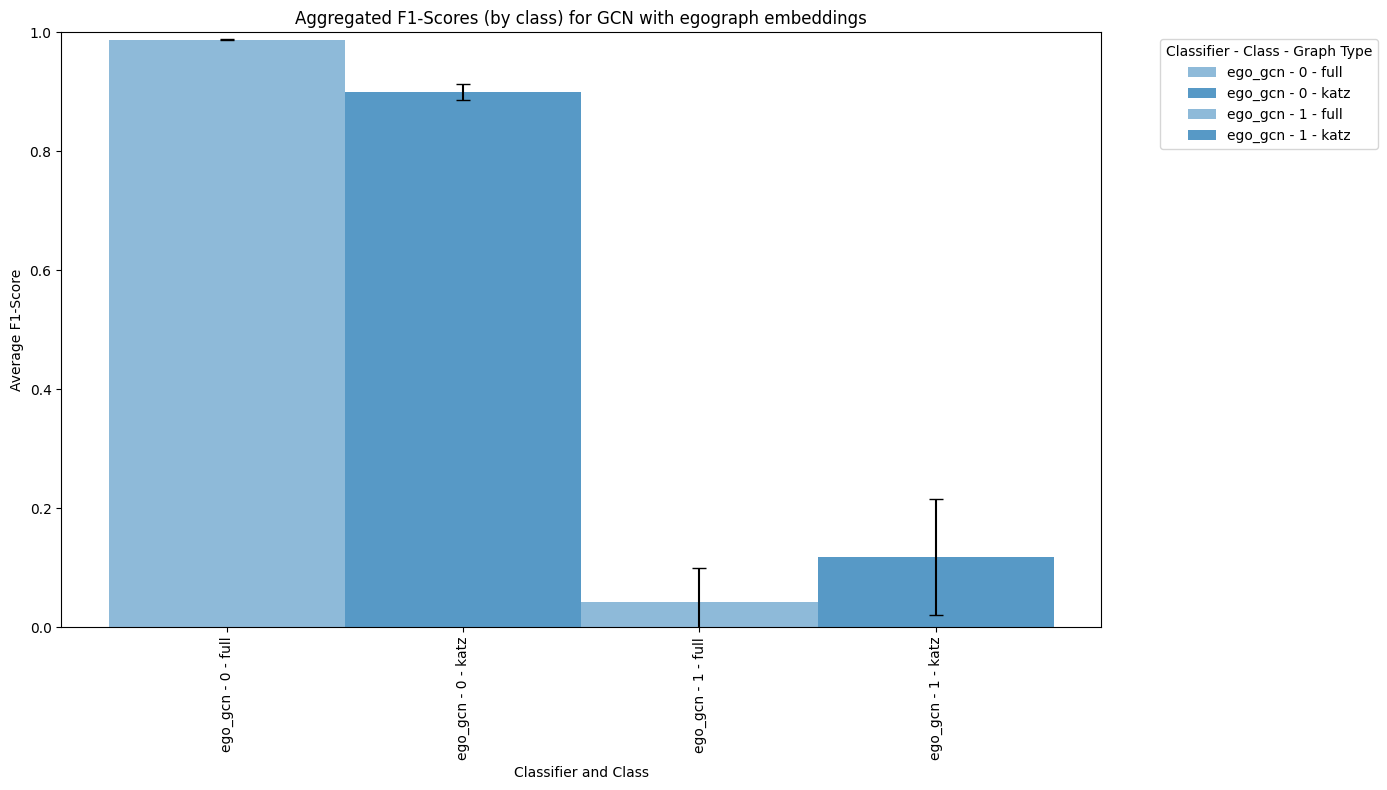

In [32]:
plot_agg(agg_gcn_embed, 'Aggregated F1-Scores (by class) for GCN with egograph embeddings')

In [ ]:
G_di = nx.DiGraph()

# Add edges from the transaction data
for index, row in transaction_data.iterrows():
    G_di.add_edge(row['From'], row['To'], weight=row['weight'], timestamp=row['TimeStamp'])

# Load phishing addresses for labeling nodes
with open('phishing-address.txt', 'r') as file:
    phishing_addresses = file.readlines()
phishing_addresses = set([address.strip().lower() for address in phishing_addresses])

# Label nodes based on phishing addresses
for node in G_di.nodes():
    G_di.nodes[node]['fraud'] = node in phishing_addresses

## Trans2Vec

In [124]:
def biased_random_walk(Graph, start_node, walk_length, alpha, timestamp="timestamp", amount="weight"):

    walk = [start_node]
    for _ in range(walk_length - 1):
        current = walk[-1]
        if current == '0':
          break
        neighbors = list(Graph.neighbors(current))
        if not neighbors: break

        # # bias selection by alpha
        if random.random() < alpha:
            # select neighbor based on amount
            weights = np.array([Graph[current][neighbor][amount] for neighbor in neighbors])
        else:
            # # select neighbor based on recency (inverse timestamp)
            weights = np.array([1.0 / Graph[current][neighbor][timestamp].timestamp() for neighbor in neighbors])

        # # normalize weights
        total_weight = weights.sum()
        if total_weight > 0:
            probabilities = weights / total_weight
            next_node = np.random.choice(neighbors, p=probabilities)
        else:
            # # if all weights are zero, pick a random neighbor
            next_node = random.choice(neighbors)

        walk.append(next_node)
    return walk

In [125]:
def get_trans2vec_embedding(Graph, num_walks=10, walk_length=20, alpha=0.5, dimensions=64, window_size=5, workers=4):
    # # adjust alpha based on your focus on amount vs. timestamp
    # # generate walks
    walks = []
    for node in Graph.nodes():
      for _ in range(num_walks):
          walks.append(biased_random_walk(Graph, node, walk_length, alpha))

    # # embed nodes
    # # convert node IDs to string as Word2Vec expects string inputs
    walks = [[str(node) for node in walk] for walk in walks]
    model = Word2Vec(walks, vector_size=dimensions, window=window_size, min_count=0, sg=1, workers=workers)

    return model

In [128]:
t2v_model = get_trans2vec_embedding(G_di, num_walks=10, walk_length=20, alpha=0.5, dimensions=64, window_size=5)

# # 'G' is the graph where each node has a 'phishing' attribute indicating if it's involved in phishing
node_labels = {str(node): G_di.nodes[node]['fraud'] for node in G_di.nodes()}

# # Extract embeddings for nodes that have labels
t2v_embeddings = []
t2v_labels = []
for node in G_di.nodes():
    node_str = str(node)  # Convert node to string to match dictionary keys
    if node_str in t2v_model.wv:
        t2v_embeddings.append(t2v_model.wv[node_str])
        if node_str in node_labels:
            t2v_labels.append(node_labels[node_str])
        else:
            print(f"No label found for node {node_str}, skipping...")  # handle missing labels

t2v_embeddings = np.array(t2v_embeddings)
t2v_labels = np.array(t2v_labels)

# # Encode labels
t2v_label_encoder = LabelEncoder()
t2v_targets = t2v_label_encoder.fit_transform(t2v_labels)

In [132]:
trans2vec_results_df = pd.DataFrame(columns=['Classifier', 'Iteration', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Class'])
trans2vec_results_list = []

for i in range(10):
  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(t2v_embeddings, t2v_targets, test_size=0.3)
  smote = SMOTE()
  X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # upsample fraud nodes using smote for class imbalance
  # #Scale features (important for SVM)
  scaler = StandardScaler()
  X_train_resampled = scaler.fit_transform(X_train_resampled)
  X_test = scaler.transform(X_test)
  # Define classifiers
  classifiers = {
      "Logistic Regression": LogisticRegression(),
      "SVM": SVC(),
      "Random Forest": RandomForestClassifier(n_estimators=100),
      "KNN": KNeighborsClassifier(n_neighbors=3)
  }

  # # Train classifiers and evaluate
  for name, clf in classifiers.items():
      clf.fit(X_train_resampled, y_train_resampled)
      y_pred = clf.predict(X_test)
      print(f"{name} Classification Report:")
      print(classification_report(y_test, y_pred))
      print(f"{name} Accuracy:", accuracy_score(y_test, y_pred))

      accuracy = accuracy_score(y_test, y_pred)
      precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0,1])

      # # Store results for each class
      for cls_index, cls in enumerate([0, 1]):
          trans2vec_results_list.append({
              'Classifier': name,
              'Iteration': i,
              'Accuracy': accuracy,
              'Precision': precision[cls_index],
              'Recall': recall[cls_index],
              'F1-Score': f1_score[cls_index],
              'Class': cls
          })


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93     11365
           1       0.12      0.67      0.21       273

    accuracy                           0.88     11638
   macro avg       0.56      0.78      0.57     11638
weighted avg       0.97      0.88      0.92     11638

Logistic Regression Accuracy: 0.8776422065647018
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     11365
           1       0.25      0.75      0.38       273

    accuracy                           0.94     11638
   macro avg       0.62      0.85      0.67     11638
weighted avg       0.98      0.94      0.96     11638

SVM Accuracy: 0.9414847912012373
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11365
           1       0.38      0.64      0.47     

In [134]:
trans2vec_results_df = pd.DataFrame(trans2vec_results_list)
display(trans2vec_results_df)
trans2vec_results_df.to_csv('trans2vec df.csv')

,Classifier,Iteration,Accuracy,Precision,Recall,F1-Score,Class
0,Logistic Regression,0,0.877642,0.991205,0.882534,0.933718,0
1,Logistic Regression,0,0.877642,0.121132,0.673993,0.205357,1
2,SVM,0,0.941485,0.993807,0.945974,0.969301,0
3,SVM,0,0.941485,0.251220,0.754579,0.376944,1
4,Random Forest,0,0.966575,0.991228,0.974395,0.982739,0
...,...,...,...,...,...,...,...
75,SVM,9,0.947414,0.259972,0.718631,0.381818,1
76,Random Forest,9,0.967091,0.990189,0.976000,0.983043,0
77,Random Forest,9,0.967091,0.359155,0.581749,0.444122,1
78,KNN,9,0.959100,0.991965,0.965978,0.978799,0


In [135]:
# # show aggregated results for each classifier by class

trans2vec_agg_results = agg_results(trans2vec_results_df, 'F1-Score', ['Classifier', 'Class'])
trans2vec_agg_results

,Classifier,Class,Mean_F1,SD_F1
0,KNN,0,0.978592,0.001193
1,KNN,1,0.424050,0.017709
2,Logistic Regression,0,0.933538,0.002528
3,Logistic Regression,1,0.208831,0.010094
4,Random Forest,0,0.983425,0.000955
5,Random Forest,1,0.474362,0.027821
6,SVM,0,0.971811,0.001896
7,SVM,1,0.389723,0.018125


In [136]:
# # show aggregated results for each classifier by class, classes combined

agg_results(trans2vec_results_df, 'F1-Score', ['Classifier'])

,Classifier,Mean_F1,SD_F1
0,KNN,0.701321,0.284736
1,Logistic Regression,0.571185,0.371836
2,Random Forest,0.728893,0.261846
3,SVM,0.680767,0.298869


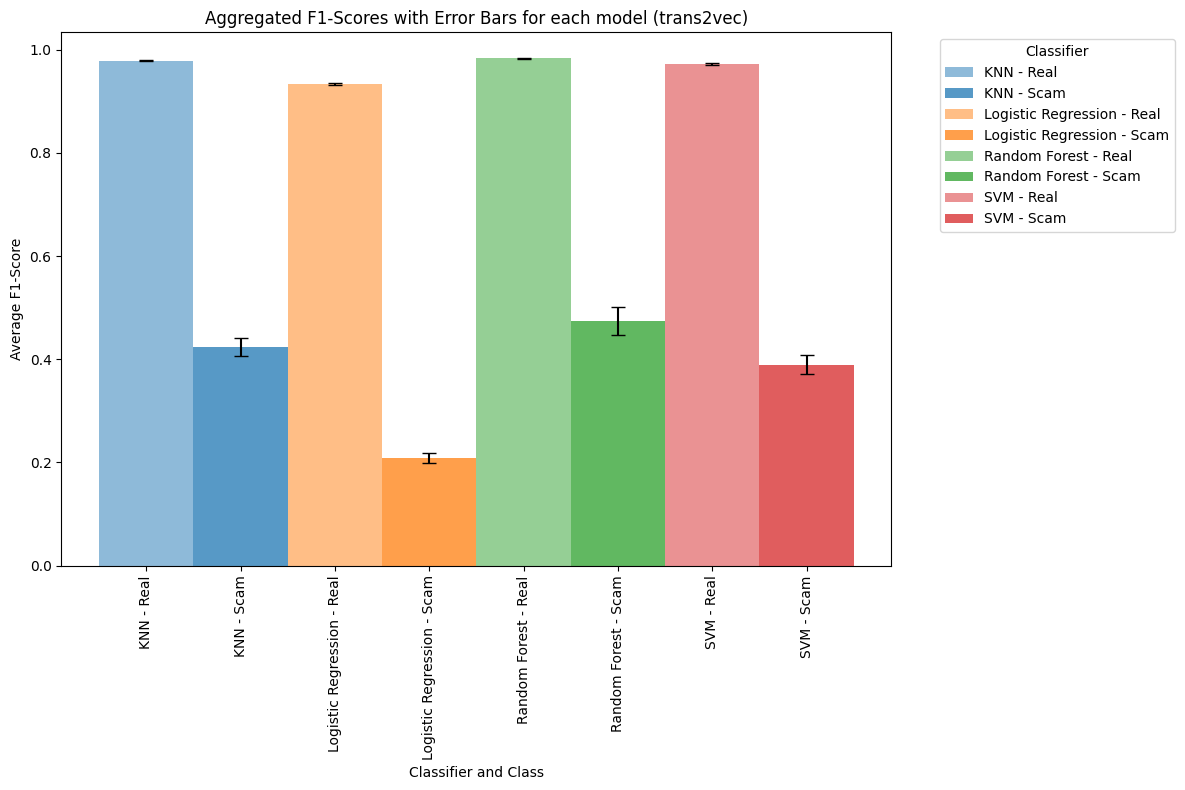

In [139]:
plot_results(trans2vec_agg_results, 'Aggregated F1-Scores with Error Bars for each model (trans2vec)')

## AnonymousWalk

In [ ]:
df = pd.read_csv('df.csv')
df.rename(columns={'Unnamed: 0': 'graph_index'}, inplace=True)
# reconstruct every graph from the combined dataframe
graphs = []

for idx, i in enumerate(df.graph_index):
    if i == 0:
        graphs.append([])
    graphs[-1].append(df.iloc[idx])

# convert each graph to a dataframe
for i in range(len(graphs)):
    graphs[i] = pd.DataFrame(graphs[i])

# print the total number of graphs
print("Number of graphs: ", len(graphs))

In [ ]:
# convert the graph dataframes to networkx graphs
networkx_graphs = []
for graph_df in graphs:
    # create a directed graph
    G = nx.from_pandas_edgelist(graph_df, source='From', target='To', edge_attr=True)
    networkx_graphs.append(G)

# define a utility function to check if a graph contains any phishing addresses
def is_phishing(G, phishing_addresses):
    for node in G.nodes():
        if node in phishing_addresses:
            return True
    return False

# create labels for each graph
# 1 for phishing transactions
# 0 for normal transactions
labels = [is_phishing(G, phishing_addresses_list) for G in networkx_graphs]

In [ ]:
!curl -O https://raw.githubusercontent.com/nd7141/AWE/master/AnonymousWalkKernel.py

In [ ]:
from AnonymousWalkKernel import GraphKernel

# create a graph kernel from all the graphs
gk = GraphKernel(graphs=networkx_graphs)

# embed graphs
length = 3
gk.embed_graphs(steps=length, keep_last=True)
E = gk.embeddings

# display dimensions
print('Embeddings matrix of shape: {} x {}'.format(E.shape[0], E.shape[1]))
print(E[:10, :])

In [ ]:
# calculate rbf kernel from the graph kernel
gk.kernel_matrix(kernel_method='rbf', build_embeddings=False)
K = gk.K
print('Kernel matrix has shape: {} x {}'.format(K.shape[0], K.shape[1]))
print(K[:1, :])